# Imports

In [4]:
include("/Users/wladi/Projects/TFIPerturbationTheory/src/PertTheory.jl")
include("./params.jl")
using CairoMakie
using Integrals

  Activating project at `~/Projects/TFIPerturbationTheory`


In [102]:
function sgn(x)
    return x == 0 ? Int(0) : Int(x/abs(x))
end

function laguerre(x::T, N::Int) where T
    p0, p1 = one(T), -x+1
    N == 0 && return p0
    for k = one(T):N-1
        p1, p0 = ((2k+1)/(k+1) - x/(k+1))*p1 - k/(k+1)*p0, p1
    end
    p1
end

function get_samples(f, N::Int; n_samples::Int = 10000, dx::Float64 = 1e-4)

    f_abs(x, N) = abs(f(x, N))

    # points = first(domain):dx:last(domain)
    # f_points = f.(collect(points))
    # f_abs_points = abs.(f_points)
    # sum_f_abs_points = sum(f_abs_points)

    domain = (0, 2*sqrt(2*N))
    prob_f_mean = IntegralProblem((x,n) -> x*f(x,n), domain, N)
    f_mean = solve(prob_f_mean, HCubatureJL(), reltol = 1e-3, abstol = 1e-3).u

    prob_f_var = IntegralProblem((x,n) -> x^2*f(x,n), domain, N)
    f_var = solve(prob_f_var, HCubatureJL(), reltol = 1e-3, abstol = 1e-3).u

    prob_f = IntegralProblem(f, domain, N)
    int_f = solve(prob_f, HCubatureJL(), reltol = 1e-3, abstol = 1e-3).u

    prob_f_abs = IntegralProblem(f_abs, domain, N)
    int_f_abs = solve(prob_f_abs, HCubatureJL(), reltol = 1e-3, abstol = 1e-3).u

    # return f_mean/int_f, f_var/int_f - (f_mean/int_f)^2

    @show f_mean
    @show sqrt(2N), f_mean/int_f

    points = 0:dx:2*f_mean/int_f
    f_abs_points = f_abs.(collect(points), N)
    cum_f_abs = cumsum((dx * f_abs_points) ./ int_f_abs)

    probs = rand(n_samples)

    samples = [findmin(abs.(cum_f_abs .- u))[2]*dx for u in probs]
    signs = sgn.(f.(samples,N))
    prefactor = int_f_abs / int_f

    return samples, signs, prefactor
end

get_samples (generic function with 2 methods)

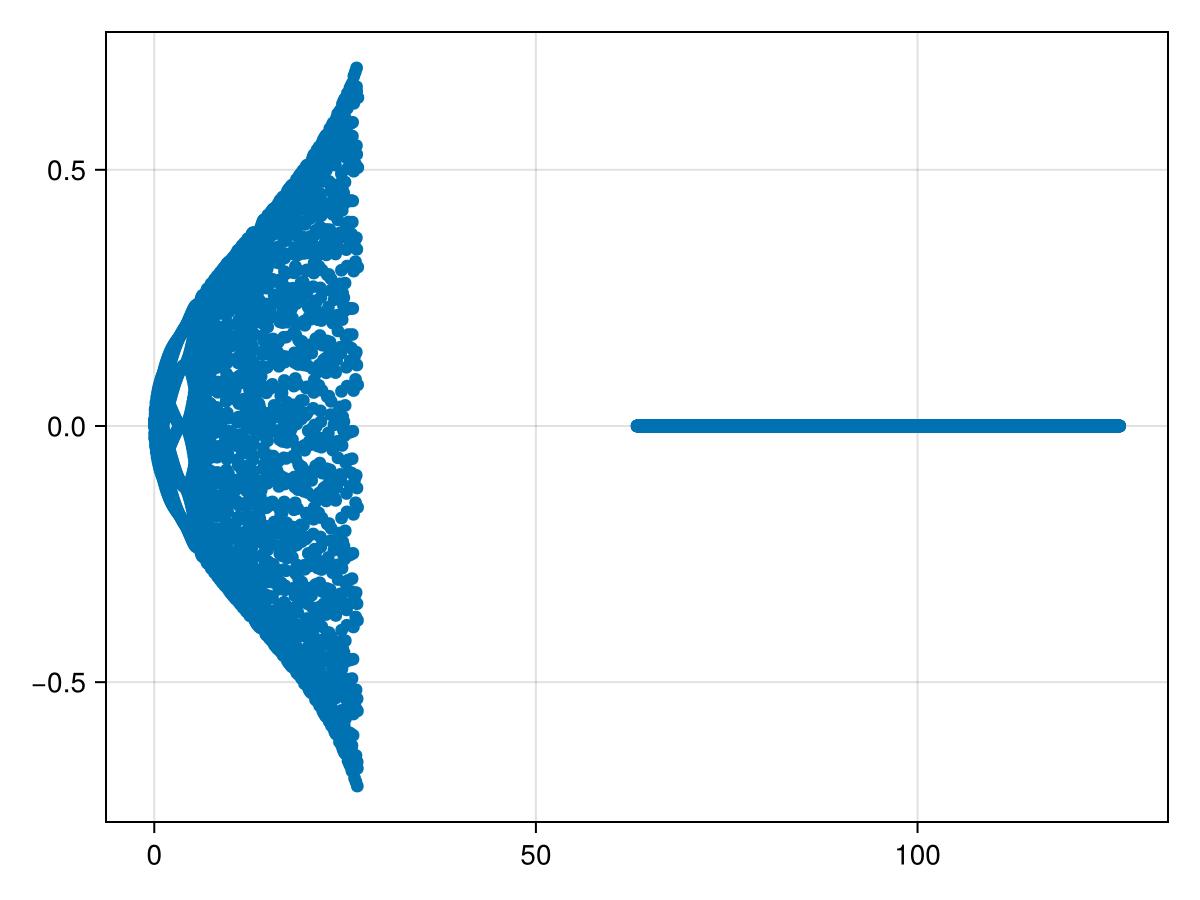

In [111]:
# for N in [3,10,20,50,100,200,300,400,500]
# for x in [3,10,20,50,100,200,300,400,500]
x = collect(0:0.01:4*sqrt(1000))
g(x,p) = x > 2*sqrt(2p) ? 0 : x*exp.(-x^2) * laguerre(2*x^2, p) 

fig = Figure()
ax = Axis(fig[1,1])

scatter!(x, g.(x,500))
fig
    # @show N, laguerre(100^2,N)
#     @show x, g(x,500)
# end

(sqrt(2N), f_mean / int_f) = (4.47213595499958, 4.579993056331319)
(sqrt(2N), f_mean / int_f) = (6.324555320336759, 6.402173439578521)
(sqrt(2N), f_mean / int_f) = (7.745966692414834, 7.809725277778644)
(sqrt(2N), f_mean / int_f) = (8.94427190999916, 8.999657201624196)
(sqrt(2N), f_mean / int_f) = (10.0, 10.04962935600185)


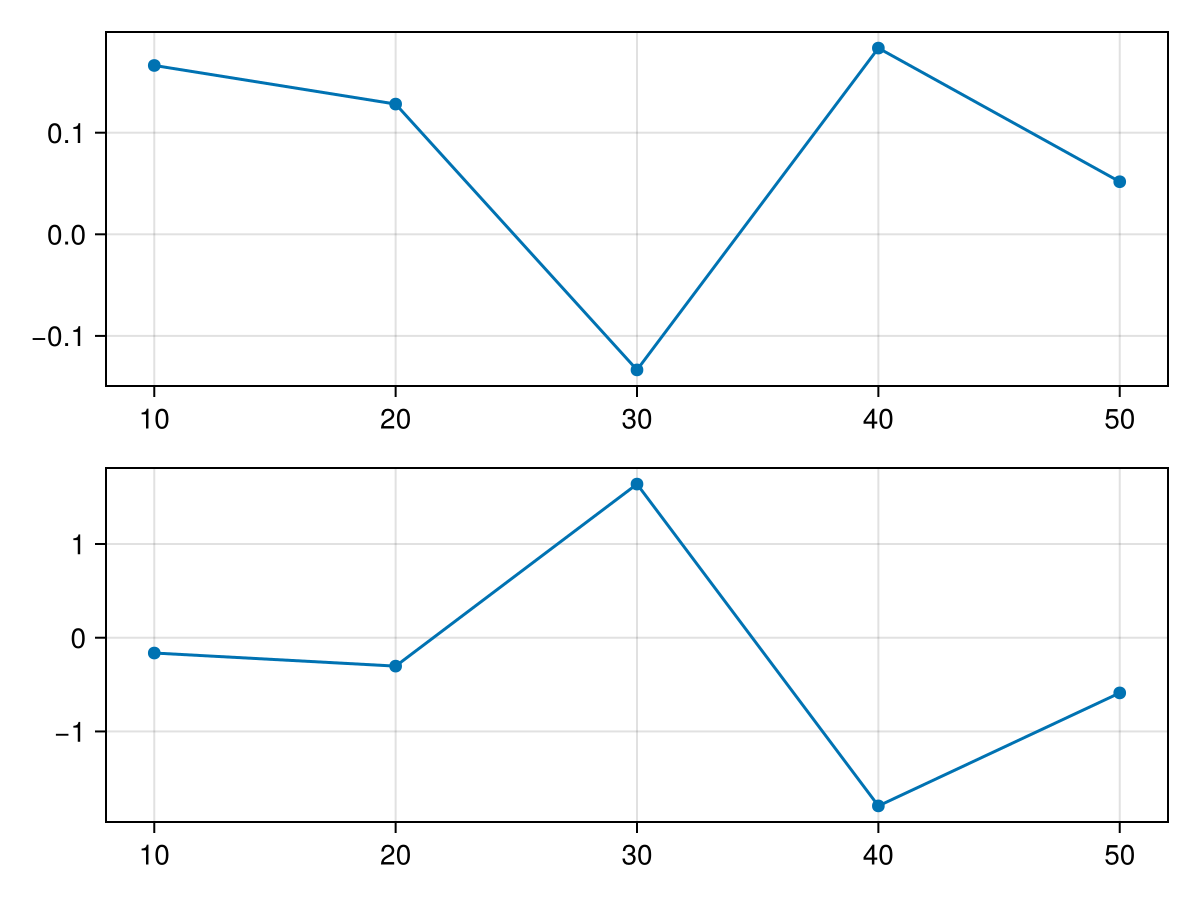

In [88]:
let 
    # f(x,p) = x*exp.(-x) * laguerre(2*x, p)

    g(x,p) = x*exp.(-x^2) * laguerre(2*x^2, p)
    f(x,p) = g(x, p)

    # f(x,p) = g(x*sqrt(2p), p)
    # f(x,p) = exp.(-x) * laguerre(2*x, p)

    fig = Figure()
    ax1 = Axis(fig[1,1])
    ax2 = Axis(fig[2,1])

    Ns = [10,20,30,40,50]

    global data = map(Ns) do N  
        samples, signs, prefactor = get_samples(f, N; n_samples=50_000)
        return prefactor, samples, signs
        return prefactor * mean(samples .* signs)
    end
    scatterlines!(ax1, Ns, [d[1] * mean(d[2] .* d[3])    for d in data] .- sqrt.(2Ns))
    scatterlines!(ax2, Ns, [d[1] * (mean(d[2].^2 .* d[3]) - d[1] * mean(d[2] .* d[3])^2) for d in data])
    # scatterlines!(ax2, Ns, [d[2] for d in data])

    fig
end

In [103]:
f(x,p) = x > 1.5*sqrt(2p) ? 0 : x*exp.(-x^2) * laguerre(2*x^2, p) 
# f(x,p) = x*exp.(-x^2) * laguerre(2*x^2, p)
N = 500

samples, signs, prefactor = get_samples(f, N; n_samples=10_000)

# fig = Figure()
# ax1 = Axis(fig[1,1])
# ax2 = Axis(fig[2,1])

println(prefactor *  mean(samples .* signs))
println(sqrt(2N))
println(prefactor * mean(samples.^2 .* signs))
println(prefactor * mean(samples .* signs)^2)

# fig

f_mean = NaN
(sqrt(2N), f_mean / int_f) = (31.622776601683793, NaN)


InexactError: InexactError: trunc(Int64, NaN)

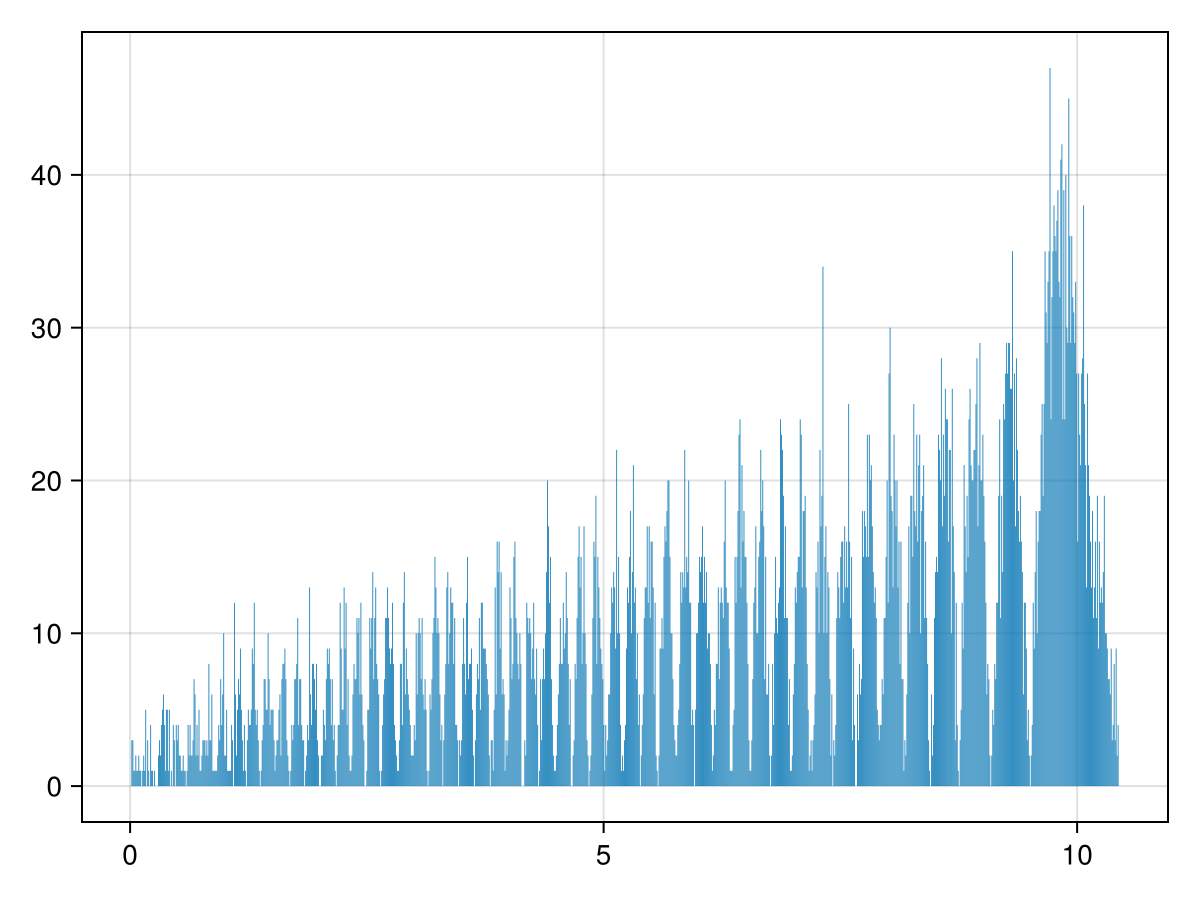

In [85]:
fig,ax,p = hist(samples; bins=1000)
fig

In [112]:
prefactor

6.443120560789661

In [114]:
1/mean(signs)

6.313131313131312

In [65]:
println(prefactor *  mean(samples .* signs))
println(sqrt(2N))
println(prefactor * mean(samples.^2 .* signs) - (prefactor * mean(samples .* signs))^2)

9.419412825889108
10.0
4.787250454533492


In [42]:
let 
    # f(x,p) = x*exp.(-x) * laguerre(2*x, p)

    g(x,p) = x*exp.(-x^2) * laguerre(2*x^2, p)
    f(x,p) = g(x*sqrt(2p), p)

    # f(x,p) = exp.(-x) * laguerre(2*x, p)

    fig = Figure()
    ax1 = Axis(fig[1,1])
    ax2 = Axis(fig[2,1])

    Ns = [10,20,30,40,50,60,70,100]

    data = map(Ns) do N  
        return get_samples(f, N)
    end
    scatterlines!(ax1, Ns, [d[1] for d in data] .- 0*sqrt.(2Ns))
    scatterlines!(ax2, Ns, [d[2] for d in data])

    fig
end

UndefVarError: UndefVarError: `f_abs_points` not defined

In [15]:
let 
    f(x,p)     = 2*x*exp.(-x) * laguerre(2*x, p)
    domain = (0, Inf) # (lb, ub)
    prob = IntegralProblem(f, domain, 10)
    @time res = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)

    points = first(domain):dx:last(domain)
end


  0.083723 seconds (291.74 k allocations: 20.225 MiB, 13.62% gc time, 99.79% compilation time)
  0.550463 seconds (62.63 k allocations: 80.533 MiB, 1.39% gc time, 2.48% compilation time)
(sum(f_points) * dx, res) = (41.99999977082516, fill(41.99999999979501))


(41.99999977082516, fill(41.99999999979501))

In [877]:
function get_samples2(f, N::Int, n_samples; dx::Float64 = 1e-3)
    domain = (0,N*4)

    # f(x)     = 2*x*exp.(-x) * laguerre(2*x, N)
    f_abs(x) = abs(f(x))
    # f_abs_mean(x) = sgn(f(x)) * x * f_abs(x)
    f_mean(x) = x * f(x)
    
    points = first(domain):dx:last(domain)

    f_points = f.(collect(points))
    f_abs_points = abs.(f_points)
    sum_f_abs_points = sum(f_abs_points)
    @show 

    cum_f_abs = cumsum(f_abs_points ./ sum_f_abs_points)

    probs = rand(n_samples)

    samples = [findmin(abs.(cum_f_abs .- u))[2]*dx for u in probs]
    signs = sgn.(f.(samples))
    prefactor = sum_f_abs_points / sum(f_points)

    return samples, signs, prefactor
end

numS = 10000
fNorm(x)     = x * exp.(-x) * laguerre(2*x, N)
datNorm = map([20,50,100]) do N
    samples, signs, prefactor = get_samples2(fNorm, N, numS)
    mean_ = prefactor * mean(signs .* samples)
    var2_ = prefactor * mean(signs .* (samples .- mean_).^2) 
    var_  = prefactor * mean(signs .* samples.^2) 
    return mean_, var2_, (var_ - mean_^2)
end

fsqroot(x)     = sqrt(x) * exp.(-x) * laguerre(2*x, N)
datsqroot = map([20,50,100]) do N
    samples, signs, prefactor = get_samples2(fsqroot, N, numS)
    mean_ = prefactor * mean(signs .* samples)
    var2_ = prefactor * mean(signs .* (samples .- mean_).^2) 
    var_  = prefactor * mean(signs .* samples.^2) 
    return mean_, var2_, (var_ - mean_^2)
end

fsq(x)     = x * exp.(-x^2) * laguerre(2*x^2, N)
datsq = map([20,50,100]) do N
    samples, signs, prefactor = get_samples2(fsq, N, numS)
    mean_ = prefactor * mean(signs .* samples)
    var2_ = prefactor * mean(signs .* (samples .- mean_).^2) 
    var_  = prefactor * mean(signs .* samples.^2) 
    return mean_, var2_, (var_ - mean_^2)
end

fno(x)     = exp.(-x) * laguerre(2*x, N)
datno = map([20,50,100]) do N
    samples, signs, prefactor = get_samples2(fno, N, numS)
    mean_ = prefactor * mean(signs .* samples)
    var2_ = prefactor * mean(signs .* (samples .- mean_).^2) 
    var_  = prefactor * mean(signs .* samples.^2) 
    return mean_, var2_, (var_ - mean_^2)
end
    # dat = map(1:50) do _
    #     samples, signs, prefactor= get_samples2(f, N, 100)
    #     return prefactor * mean(samples .* signs)
    # end

    # fig = Figure()
    # ax = Axis(fig[1,1])
    # hist!(ax, dat)

    # fig

3-element Vector{Tuple{Float64, Float64, Float64}}:
 (-226.80069143157328, -408106.4241366971, -63582.01469279385)
 (324.9820969438419, 51992.54050303747, -45718.04004676389)
 (439.70390633345204, 457.5174834889311, -16891.633267041878)

In [800]:
function get_samples2(N::Int; n_samples::Int = 10_000, dx::Float64 = 1e-3)
    fact = 1
    domain = (0,N*4)

    f(x)     = 2*fact*sqrt(x)*exp.(-fact*x) * laguerre(2*fact*x, N)
    f_mean(x) = x * f(x)

    # f_abs(x) = abs(f(x))
    # f_abs_mean(x) = sgn(f(x)) * x * f_abs(x)
    
    points = first(domain):dx:last(domain)

    f_points = f.(points)
    f_mean_points = f_mean.(points)
    mean_f = sum(f_mean_points)/ sum(f_points)
    @show mean_f

    g(x) = f(x * mean_f)
    g_abs(x) = abs(g(x))
    g_abs_mean(x) = sgn(g(x)) * x * g_abs(x)

    g_points = g.(points)
    g_abs_points = abs.(g_points)
    sum_g_abs_points = sum(g_abs_points)

    cum_g_abs = cumsum(g_abs_points ./ sum_g_abs_points)

    probs = rand(n_samples)

    samples = [findmin(abs.(cum_g_abs .- u))[2]*dx for u in probs]
    signs = sgn.(g.(samples))
    prefactor = sum_g_abs_points / sum(g_points)

    return samples, signs, prefactor, mean_f
end

get_samples2 (generic function with 2 methods)

In [801]:
dat = map(1:100) do _
    N = 200
    samples, signs, prefactor, mean_f = get_samples2(N; n_samples = 10000)
    return prefactor * mean(samples .* signs), prefactor * mean(samples.^2 .* signs)
end

fig = Figure()
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[2,1])
hist!(ax1, [d[1] for d in dat])
hist!(ax2, [d[2]-d[1]^2 for d in dat])

fig

InterruptException: InterruptException:

# Testing of Sampling


### airy-function

In [453]:
using SpecialFunctions

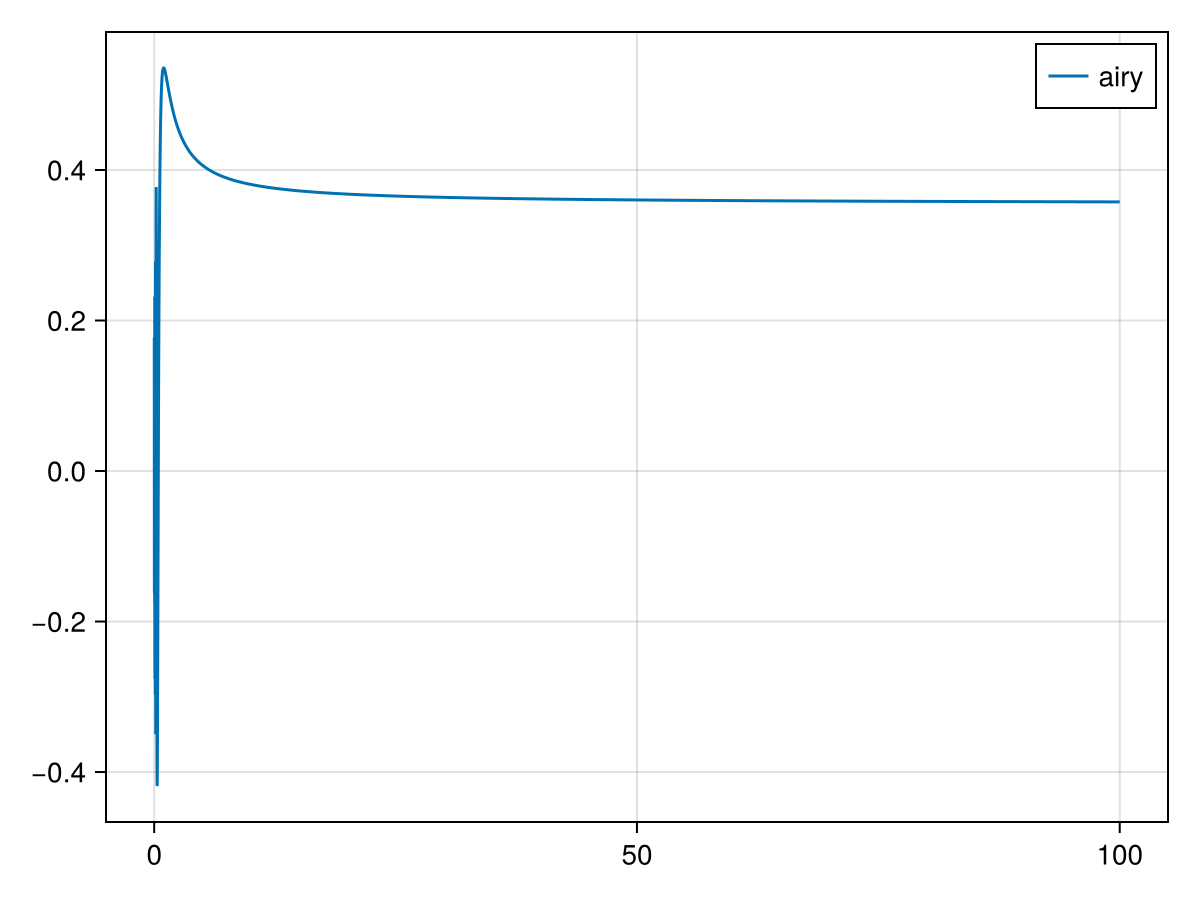

In [238]:
let
    f = Figure()
    ax = Axis(f[1,1])
    xrange = 0.01:0.01:100

    # lines!(ax, xrange, airyai.(-1 ./xrange), label = "airy")
    lines!(ax, xrange, airyai.(-1 ./xrange), label = "airy")
    axislegend(ax)
    f
    
    # vline!([sqrt(10/2)])
end

### plots

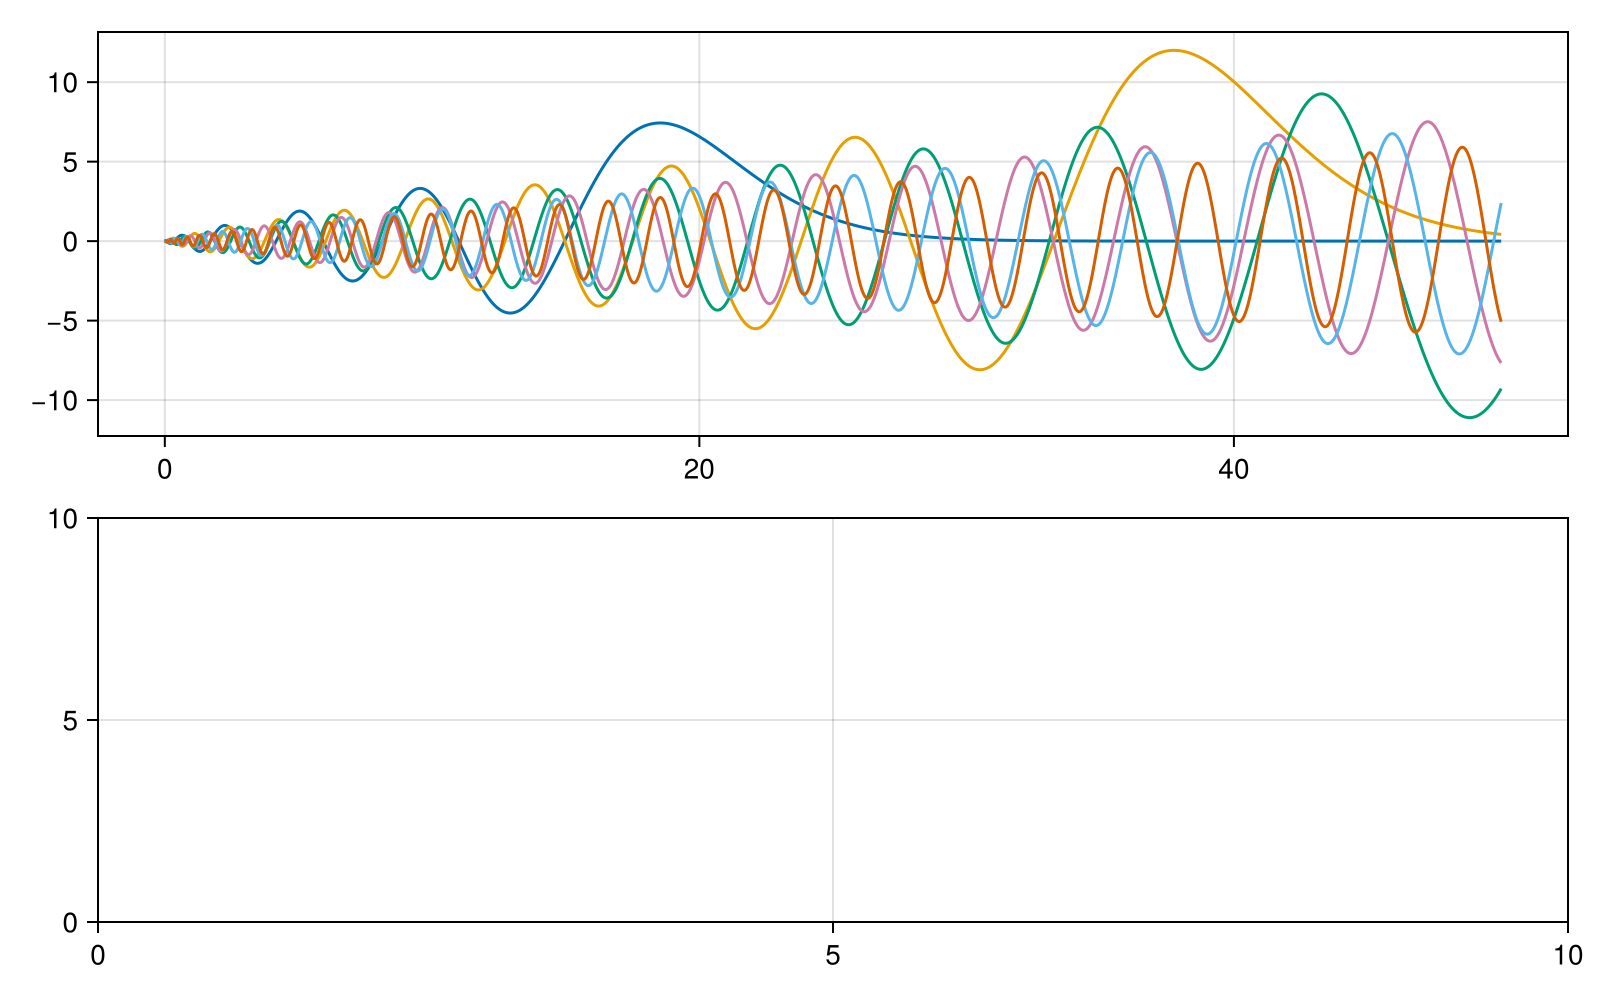

In [965]:
let
    fig = Figure(size=(800,500))
    ax = Axis(fig[1,1])#, limits=((0,51),(nothing,nothing)))
    ax2 = Axis(fig[2,1])#, limits=((0,51),(nothing,nothing)))
    xrange = 0:0.01:50

    Ns = [10,20,30,50,60,100]

    data = map(Ns) do N

        # f(x) = x*exp.(-x^2) * laguerre(2*x^2, N)
        fact = 1
        f(x) = 2*fact*x*exp.(-fact*x) * laguerre(2*fact*x, N)
        f_mean(x) = x * f(x)
        f_var(x) = x^2 * f(x)
        # f(N,x) = 2x*exp.(-x) * laguerre(2x, N)

        lines!(ax, xrange, [f(x) for x in xrange], label = "f")
        # dx = 1e-3
        # points = 0:dx:2.5

        # f_points = f.(collect(points))
        # f_mean_points = f_mean.(collect(points))
        # f_var_points = f_var.(collect(points))

        # norm, mean, var = sum(f_points)*dx, sum(f_mean_points)*dx, sum(f_var_points)*dx
        # @show norm, mean, mean/norm, var/norm - (mean/norm)^2 #"break", norm_g, mean_g, mean_g/norm_g, var_g/norm_g - (mean_g/norm_g)^2
        # return mean/norm, var/norm - (mean/norm)^2
    end

    # lines!(ax, Ns, [d[1] for d in zip(data])
    # scatter!(ax, Ns, sqrt.(2 .*Ns))
    # lines!(ax, Ns, [d[1]-sqrt(2*n) for (n,d) in zip(Ns,data)])
    # lines!(ax, Ns, [d[1]-2 for (n,d) in zip(Ns,data)])

    # lines!(Ns, [d[2] for d in data])
    fig


end

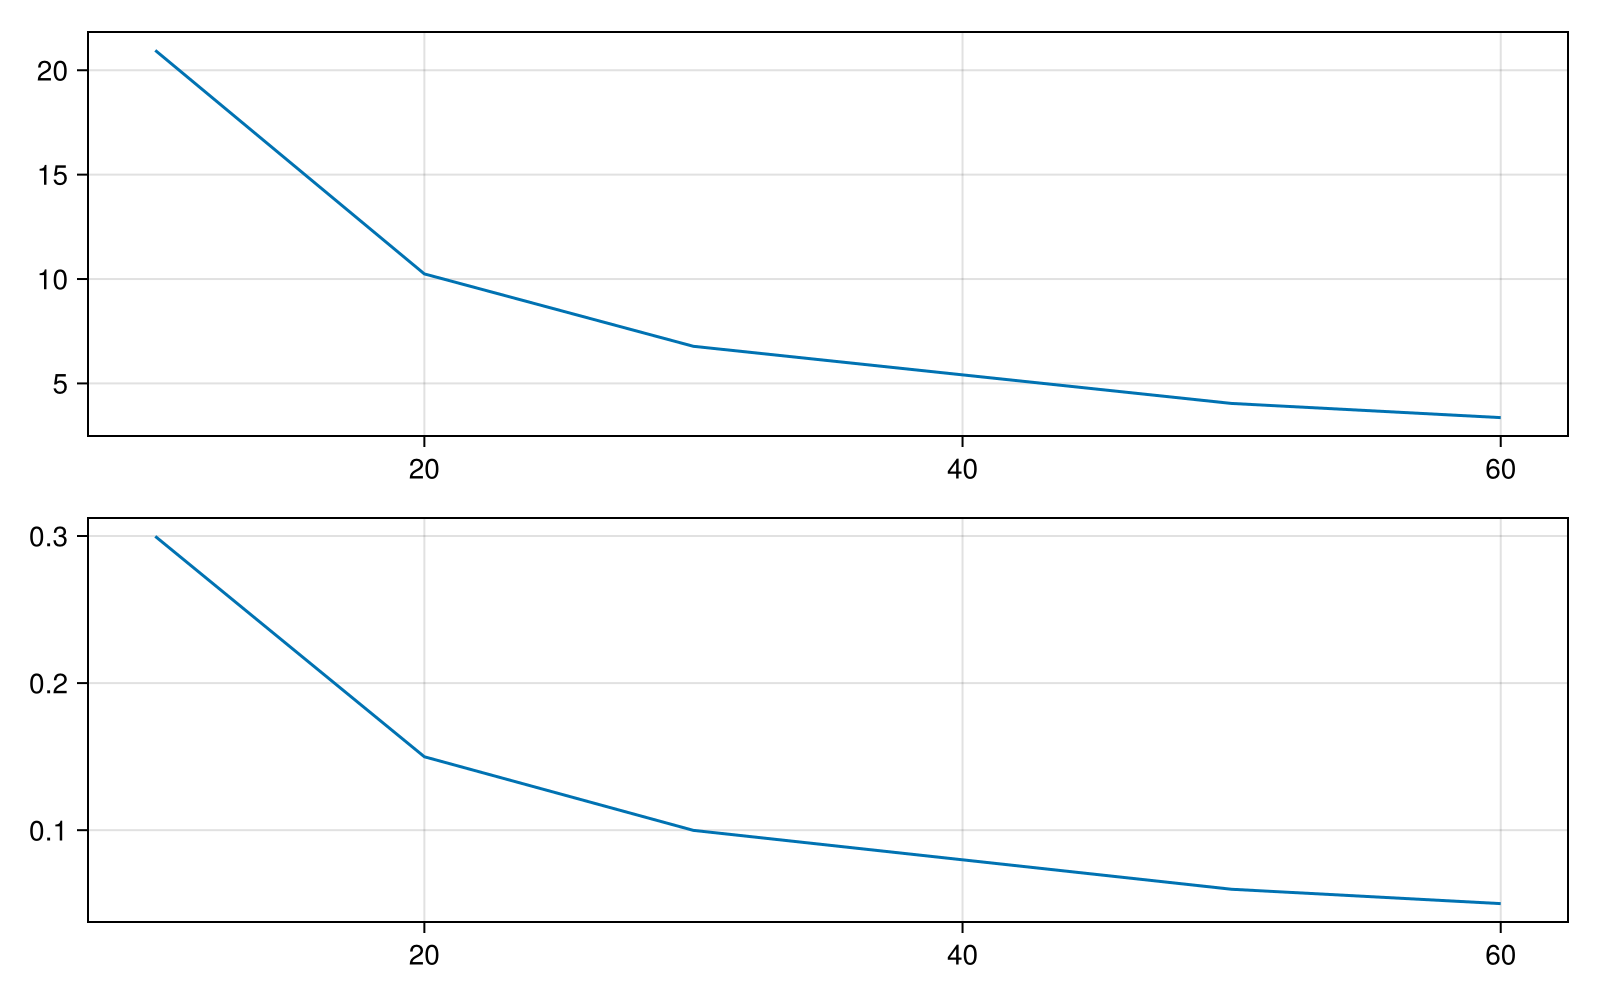

In [976]:
let
    fig = Figure(size=(800,500))
    ax = Axis(fig[1,1])#, limits=((0,51),(nothing,nothing)))
    ax2 = Axis(fig[2,1])#, limits=((0,51),(nothing,nothing)))
    xrange = 0:0.01:50

    Ns = [10,20,30,50,60,100]

    data = map(Ns) do N

        # f(x) = x*exp.(-x^2) * laguerre(2*x^2, N)
        fact = N
        f(x) = 2*fact*x*exp.(-fact*x) * laguerre(2*fact*x, N)
        f_mean(x) = x * f(x)
        f_var(x) = x^2 * f(x)
        # f(N,x) = 2x*exp.(-x) * laguerre(2x, N)

        # lines!(ax, xrange, [f(N,x) for x in xrange], label = "f")
        # axislegend(ax)
        # fig
        dx = 1e-3
        points = 0:dx:5*N

        f_points = f.(collect(points))
        f_mean_points = f_mean.(collect(points))
        f_var_points = f_var.(collect(points))

        norm, mean, var = sum(f_points)*dx, sum(f_mean_points)*dx, sum(f_var_points)*dx
        @show norm, mean, mean/norm, var/norm - (mean/norm)^2 #"break", norm_g, mean_g, mean_g/norm_g, var_g/norm_g - (mean_g/norm_g)^2
        return mean/norm, var/norm - (mean/norm)^2
    end

    # lines!(ax, Ns, [d[1] for d in zip(data])
    # scatter!(ax, Ns, sqrt.(2 .*Ns))
    # lines!(ax, Ns, [d[1]-sqrt(2*n) for (n,d) in zip(Ns,data)])

    lines!(ax, Ns, [N*(d[1]-2) for (n,d) in zip(Ns,data)])
    lines!(ax2,Ns, [n*d[2] for (n,d) in zip(Ns,data)])
    fig
end

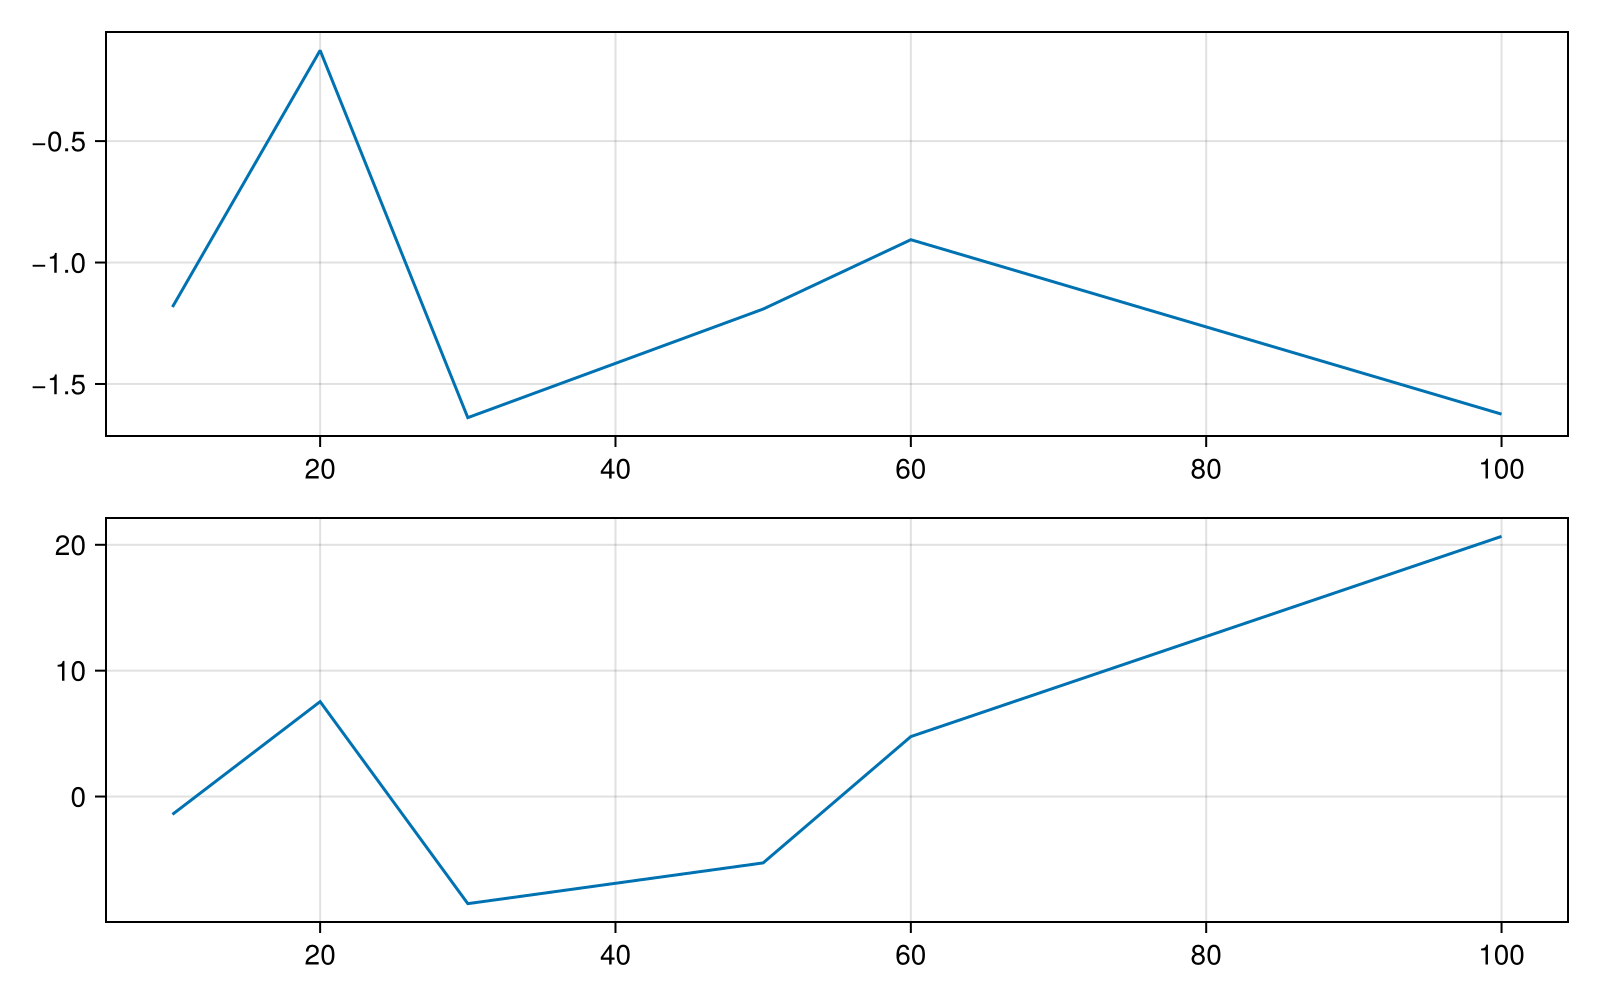

In [937]:
let
    fig = Figure(size=(800,500))
    ax = Axis(fig[1,1])#, limits=((0,51),(nothing,nothing)))
    ax2 = Axis(fig[2,1])#, limits=((0,51),(nothing,nothing)))
    xrange = 0:0.01:50

    Ns = [10,20,30,50,60,100]

    data = map(Ns) do N

        f(x) = x*exp.(-x^2) * laguerre(2*x^2, N)
        f_mean(x) = x * f(x/sqrt(2N))
        f_var(x) = x^2 * f(x/sqrt(2N))
        # f(N,x) = 2x*exp.(-x) * laguerre(2x, N)

        # lines!(ax, xrange, [f(N,x) for x in xrange], label = "f")
        # axislegend(ax)
        # fig
        dx = 1e-3
        points = 0:dx:5

        f_points = f.(collect(points))
        f_mean_points = f_mean.(collect(points))
        f_var_points = f_var.(collect(points))

        norm, mean, var = sum(f_points)*dx, sum(f_mean_points)*dx, sum(f_var_points)*dx
        @show norm, mean, mean/norm, var/norm - (mean/norm)^2 #"break", norm_g, mean_g, mean_g/norm_g, var_g/norm_g - (mean_g/norm_g)^2
        return mean/norm, var/norm - (mean/norm)^2
    end

    # lines!(ax, Ns, [d[1] for d in zip(data])
    # scatter!(ax, Ns, sqrt.(2 .*Ns))
    lines!(ax, Ns, [d[1]-1 for (n,d) in zip(Ns,data)])
    # lines!(ax, Ns, [d[1]-2 for (n,d) in zip(Ns,data)])

    lines!(Ns, [d[2] for d in data])
    fig


end

### Integration

In [920]:
sqrt(200)

14.142135623730951

In [693]:
let
    N = 200
    fact = 1
    # f(x) = 2*fact*x*exp.(-fact*x) * laguerre(2*fact*x, N)
    f(x) = x*exp.(-x) * laguerre(2*x, N)
    # f(x) = sqrt(x)*exp.(-2x) * laguerre(4*x, N)
    f_mean(x) = x * f(x)
    f_var(x) = x^2 * f(x)
    
    dx = 1e-3
    points = 0:dx:4*N

    f_points = f.(collect(points))
    f_mean_points = f_mean.(collect(points))
    f_var_points = f_var.(collect(points))

    norm, mean, var = sum(f_points)*dx, sum(f_mean_points)*dx, sum(f_var_points)*dx

    # g(x)      = f(x*(mean/norm))
    # g_mean(x) = x * g(x)
    # g_var(x)  = x^2 * g(x)


    # g_points = g.(collect(points))
    # g_mean_points = g_mean.(collect(points))
    # g_var_points = g_var.(collect(points))

    # norm_g, mean_g, var_g = sum(g_points)*dx, sum(g_mean_points)*dx, sum(g_var_points)*dx
    @show norm, mean, mean/norm, var/norm - (mean/norm)^2 #"break", norm_g, mean_g, mean_g/norm_g, var_g/norm_g - (mean_g/norm_g)^2

    # fig = Figure()
    # ax = Axis(fig[1,1])
    # xrange = 0:0.01:2.5

    # # g(x) = f(x*(mean/norm))
    # # (x) = fact*x*exp.(-fact*x/2) * laguerre(fact*x, N)
    # # for N in [10,20,30,40]
    # for N in [100]
    #     fact = N
    #     lines!(ax, xrange, [g(x) for x in xrange], label = "g")
    #     lines!(ax, xrange, [g_mean(x) for x in xrange], label = "f")
    # end
    # axislegend(ax)
    # fig
end

(400.9999999170008, 160801.99999999977, 401.0024938485852, 2.9999604988552164)

### Sampling: Inverse transform sampling

Check if works -> done

In [702]:
let
    N = 10
    fact = 1
    domain = (0,40)
    f(x)     = 4*fact*x*exp.(-2fact*x) * laguerre(4*fact*x, N)
    f(x)     = 2*fact*x*exp.(-fact*x) * laguerre(2*fact*x, N)
    f_abs(x) = abs(f(x))
    f_mean(x) = x * f(x)
    f_var(x) = x^2 * f(x)
    
    dx = 1e-3
    points = first(domain):dx:last(domain)

    f_points = f_abs.(collect(points))
    norm = sum(f_points)*dx

    cum_f = cumsum(f_points .* (dx/norm))

    data = map(1:1000) do _
        u = rand()
        return findmin(abs.(cum_f .- u))[2]*dx
    end
    
    fig = Figure()
    ax = Axis(fig[1,1])
    hist!(ax, data, bins = 500)
    ax2 = Axis(fig[2,1])
    lines!(ax2, f_points)
    @show mean(data), mean(data.^2)
    # fig
end

(16.606616000000002, 309.92920107400005)

In [958]:
function get_samples(N::Int; n_samples::Int = 10000, dx::Float64 = 1e-3)
    fact = 1
    domain = (0,2N)

    f(x)     = 2*fact*x*exp.(-fact*x^2) * laguerre(2*fact*x^2, N)
    f(x)     = 2exp.(-2x) * laguerre(4*x, N)
    # f(x) = x*exp.(-x^2) * laguerre(2*x^2, N)
    f(x) = x*exp.(-x) * laguerre(2*x^2, N)
    f_abs(x) = abs(f(x))
    f_abs_mean(x) = sgn(f(x)) * x * f_abs(x)
    f_mean(x) = x * f(x)
    
    points = first(domain):dx:last(domain)

    f_points = f.(collect(points))
    f_abs_points = abs.(f_points)
    sum_f_abs_points = sum(f_abs_points)

    cum_f_abs = cumsum(f_abs_points ./ sum_f_abs_points)

    probs = rand(n_samples)

    samples = [findmin(abs.(cum_f_abs .- u))[2]*dx for u in probs]
    signs = sgn.(f.(samples))
    prefactor = sum_f_abs_points / sum(f_points)

    return samples, signs, prefactor, sum(f_mean.(points))/ sum(f_points)
end

let
    N = 100
    num_samples = [100,1000,10000]
    data = map(num_samples) do n_samples
        samples, signs, prefactor, mean_f = get_samples(N; n_samples)
        mean_ = prefactor*mean(samples .* signs)
        var  = prefactor*mean(samples.^2 .* signs) - mean_^2
        # @show mean_, var, sqrt(2*N), mean_f
        return mean_, var
    end
    @show data
    
    # fig = Figure()
    # ax = Axis(fig[1,1], )#limits = (domain, (0,15)))
    # lines!(ax, num_samples, [d[1]-0*sqrt(200) for d in data])
    # ax2 = Axis(fig[2,1], )#limits = (domain, (nothing,nothing)))
    # lines!(ax2, num_samples, [d[2] for d in data])

    # fig
end

3-element Vector{Tuple{Float64, Float64}}:
 (NaN, NaN)
 (NaN, NaN)
 (NaN, NaN)

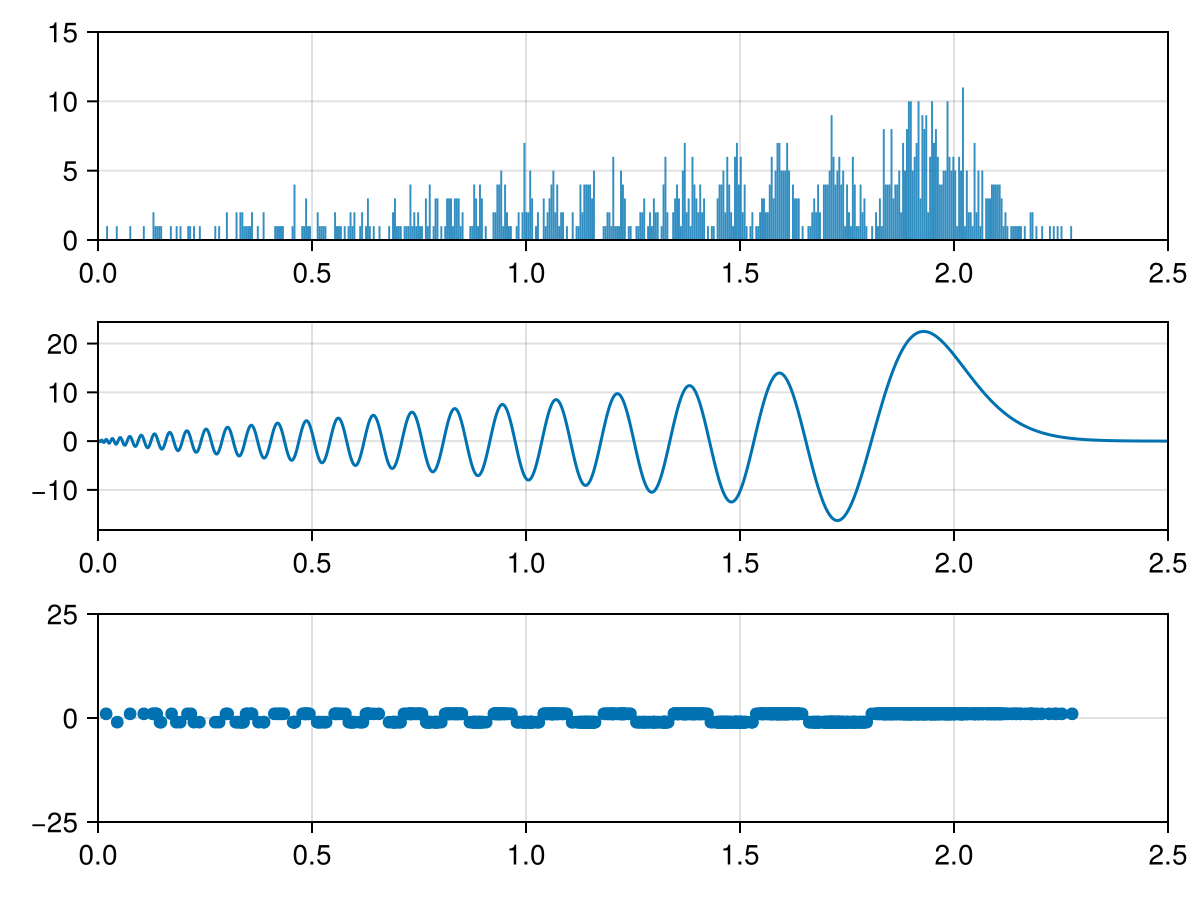

In [131]:
let
    N = 50
    fact = N
    domain = (0,2.5)
    f(x)     = 2*fact*x*exp.(-fact*x) * laguerre(N, 2*fact*x)
    f_abs(x) = abs(f(x))
    f_mean(x) = x * f(x)
    f_var(x) = x^2 * f(x)
    
    dx = 1e-3
    points = first(domain):dx:last(domain)

    f_points2 = f.(collect(points))
    f_points = f_abs.(collect(points))
    norm = sum(f_points)*dx

    cum_f = cumsum(f_points .* (dx/norm))

    data = map(1:1000) do _
        u = rand()
        return findmin(abs.(cum_f .- u))[2]
    end
    @show data
    
    
    fig = Figure()
    ax = Axis(fig[1,1], limits = (domain, (0,15)))
    hist!(ax, data .* dx, bins = 500)
    ax2 = Axis(fig[2,1], limits = (domain, (nothing,nothing)))
    lines!(ax2, points, f_points2)
    ax3 = Axis(fig[3,1], limits = (domain, (-25,25)))
    CairoMakie.scatter!(ax3, data.*dx, sgn.(f_points2[data]))


    fig
end

In [704]:
let
    N = 10
    fact = 1
    domain = (0,50)
    f(x)     = 2*fact*x*exp.(-fact*x) * laguerre(2*fact*x,1)
    f_abs(x) = abs(f(x))
    f_mean(x) = x * f(x)
    f_var(x) = x^2 * f(x)
    
    dx = 1e-3
    points = first(domain):dx:last(domain)

    f_points = f.(collect(points))
    norm = sum(f_points)*dx
    f_abs_points = abs.(f_points)
    # f(x) = 2*fact*x*exp.(-fact*x) * laguerre(N, 2*fact*x)/norm

    cum_f = cumsum(f_points .* (dx/norm))

    data = map(1:100000) do _
        u = rand()
        return findmin(abs.(cum_f .- u))[2]*dx
    end
    
    # fig = Figure()
    # ax = Axis(fig[1,1])
    # hist!(ax, data, bins = 500)
    # ax2 = Axis(fig[2,1])
    # lines!(ax2, f_points)

    # # f,_,_ = lines(cum_f)
    # # hlines!([u])
    # fig

    # f_mean_points = f_mean.(collect(points))
    # f_var_points = f_var.(collect(points))
    
    # norm, mean, var = sum(f_points)*dx, sum(f_mean_points)*dx, sum(f_var_points)*dx
    # @show norm, mean/norm, var/norm - (mean/norm)^2
end

(-6.000000166666625, 3.3333332407407745, 2.8888891172838207)

# Plots

### Initial Fock state with phi random

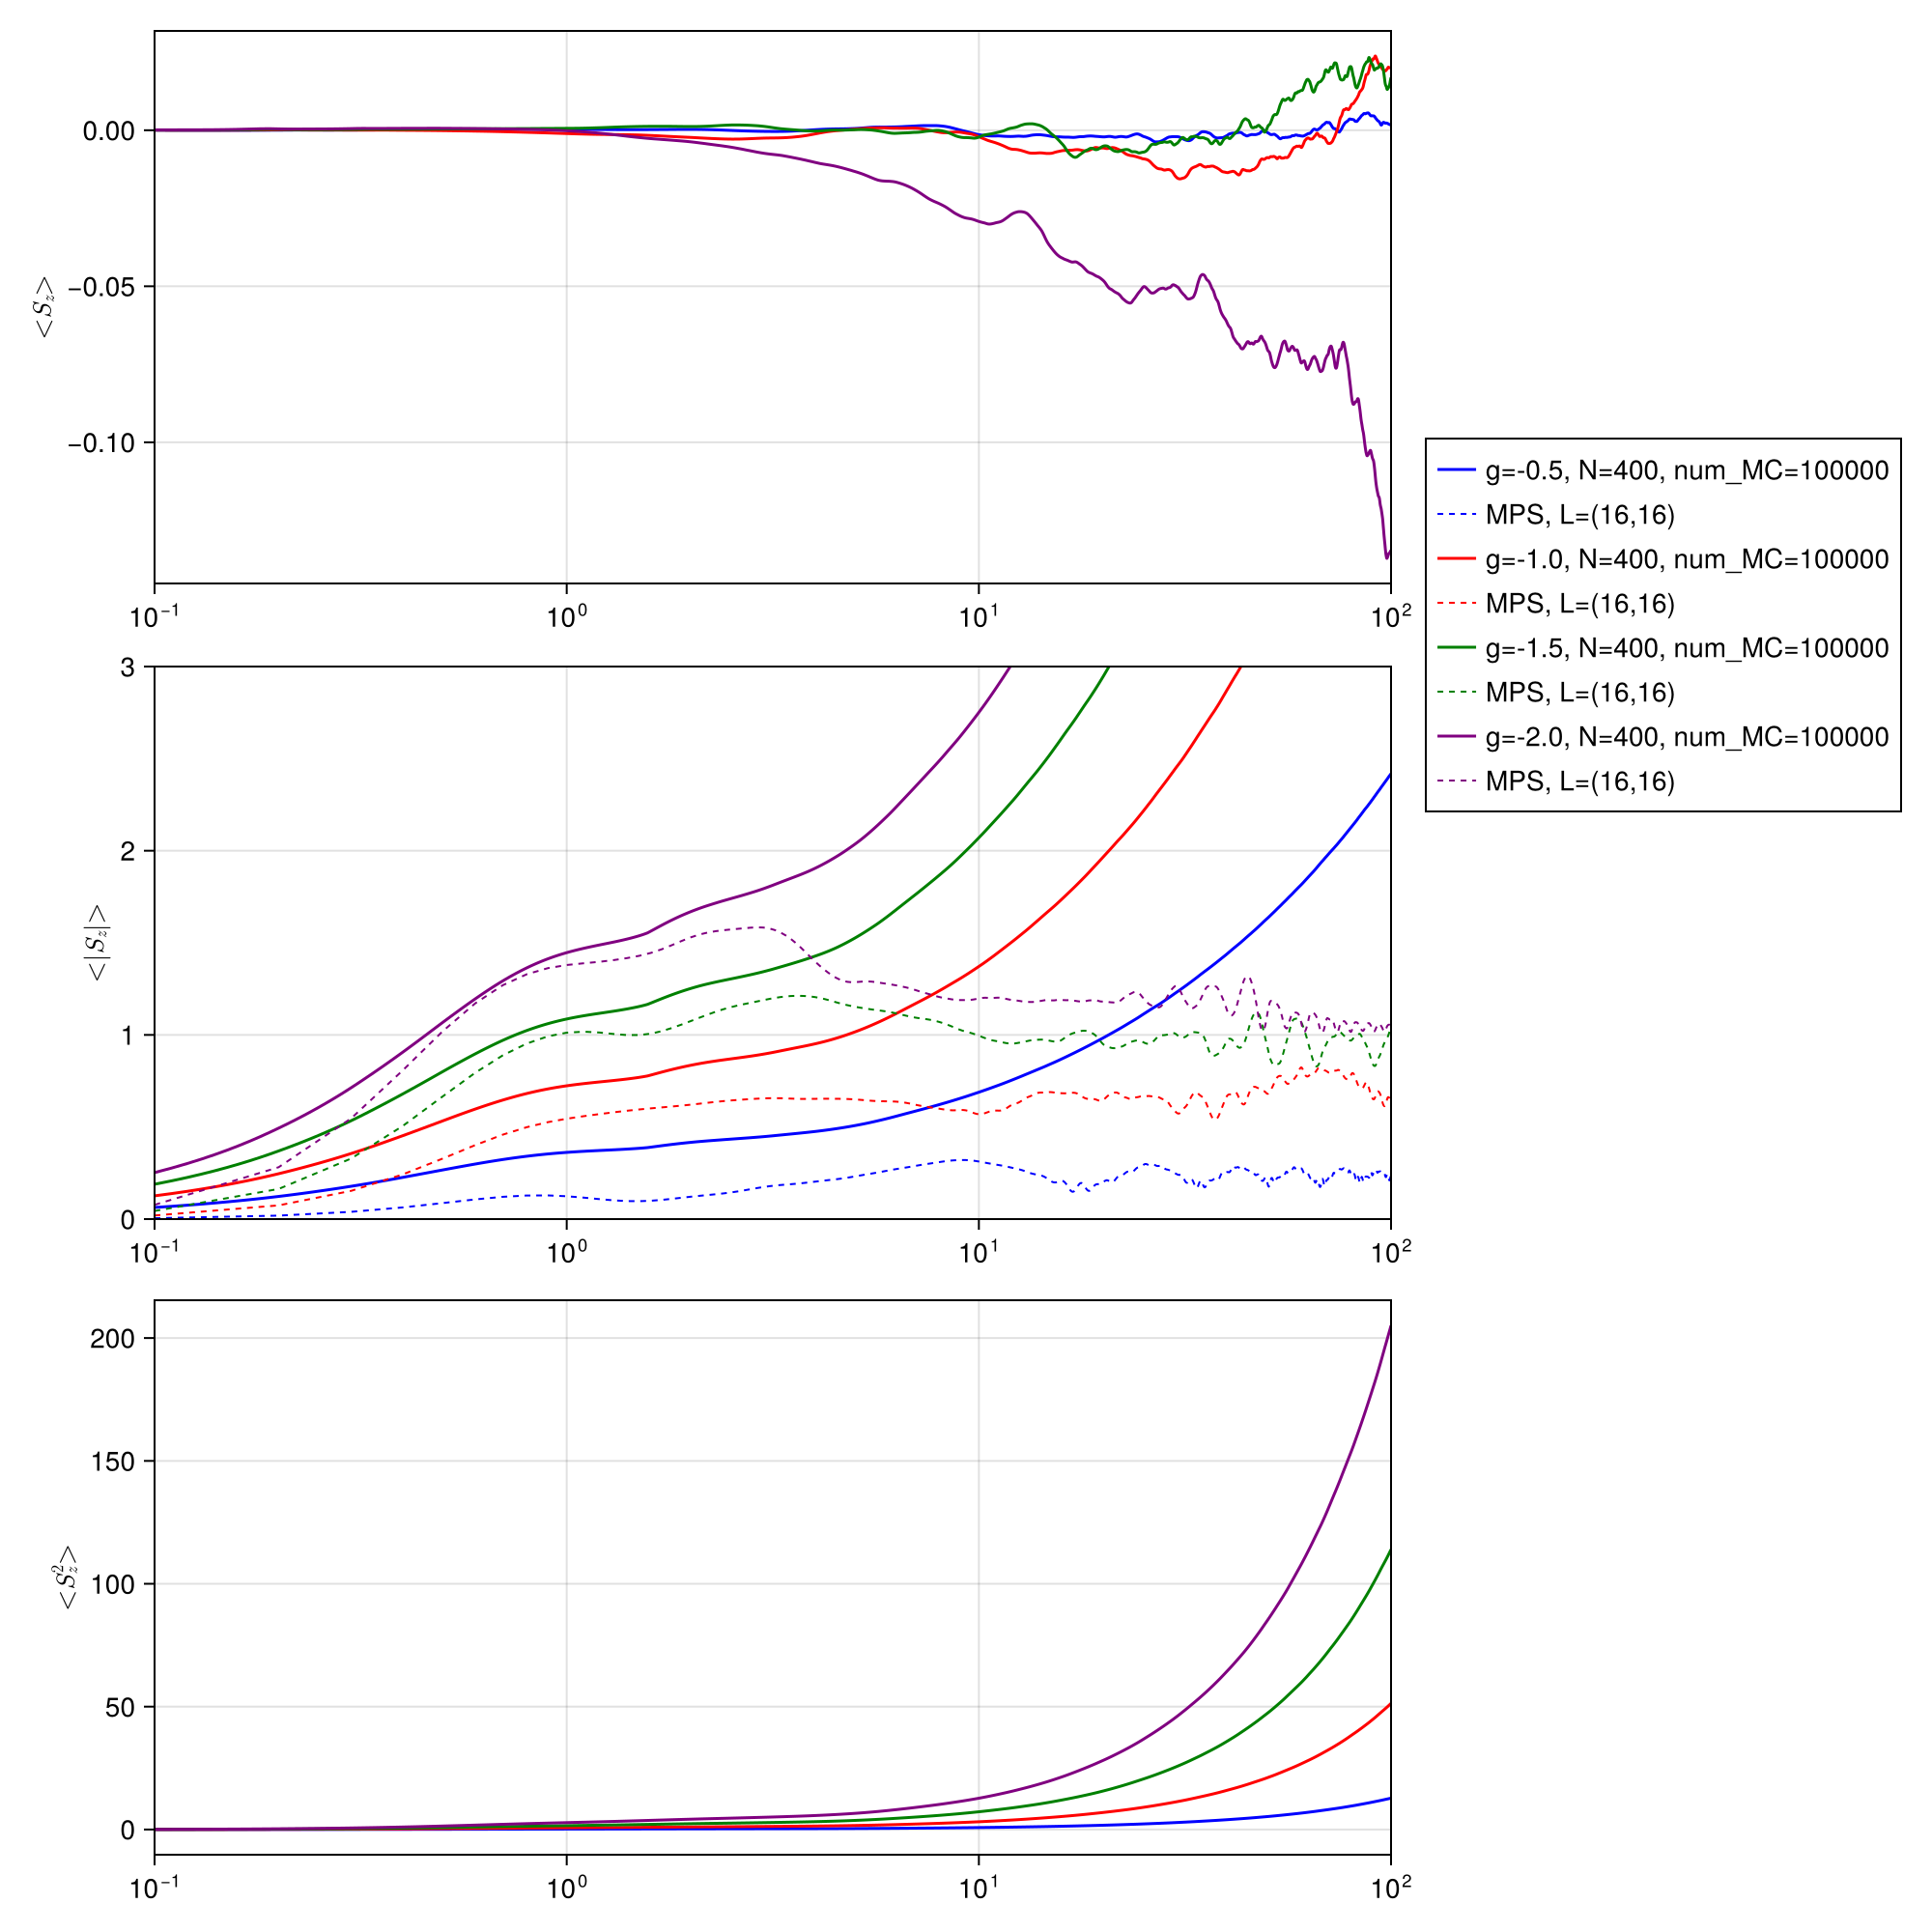

In [893]:
path = "/Users/wladi/Projects"

gs      = [-0.5,-1.0,-1.5,-2.0]#,-1.5]
Ns      = [400]
num_MCs = [100000]#, 10_000]
L=10

params = collect(Iterators.product(gs, Ns, num_MCs))

colors = [:blue, :red, :green, :purple, :black, :orange, :grey] 
fig = Figure(size=(1000,1000))
ax1 = Axis(fig[1,1], 
    xscale = log10, limits = ((0.1,100),(nothing,nothing)),
    ylabel = L"<S_z>",
)
ax2 = Axis(fig[2,1], 
    xscale = log10, limits = ((0.1,100),(0,3)),
    ylabel = L"<|S_z|>",
)
ax3 = Axis(fig[3,1], 
    xscale = log10, limits = ((0.1,100),(nothing,nothing)),
    ylabel = L"<S_z^2>",
)

data = map(enumerate(params)) do (i,(g, N, num_MC))
    S = div(N,2)
    name = path * "/TFIPerturbationTheory/data/TWA_SG_fockState_L=$(L)_Sz=$(S)_num_MC=$(num_MC)_g=$(g).csv"
    df    = CSV.read(name, DataFrame)
    dfMPS = CSV.read("/Users/wladi/Projects/TFIPerturbationTheory/data/obs_hardcoreBosons_mps_new_L=16_Sz=8_g=$(g)_bondDim=64_tmax=100.csv", DataFrame)
    # return N, g, num_MC, df[1, "meanSz"]

    lines!(ax1, df[:,"t"], df[:,"meanSz"], color = colors[i], label = "g=$g, N=$N, num_MC=$(num_MC)")
    lines!(ax2, df[:,"t"], df[:,"absSz"],  color = colors[i], label = "g=$g, N=$N, num_MC=$(num_MC)")
    lines!(ax2, 0.1*collect(1:length(dfMPS[:, "Nabs"])), dfMPS[:, "Nabs"], label = "MPS, L=(16,16)", color = colors[i], linewidth = 1, linestyle = :dash)
    lines!(ax3, df[:,"t"], df[:,"meanSz2"], color = colors[i])
end
Legend(fig[1:2,2], ax2)

fig

### Initial Fock state with added variance and phi random

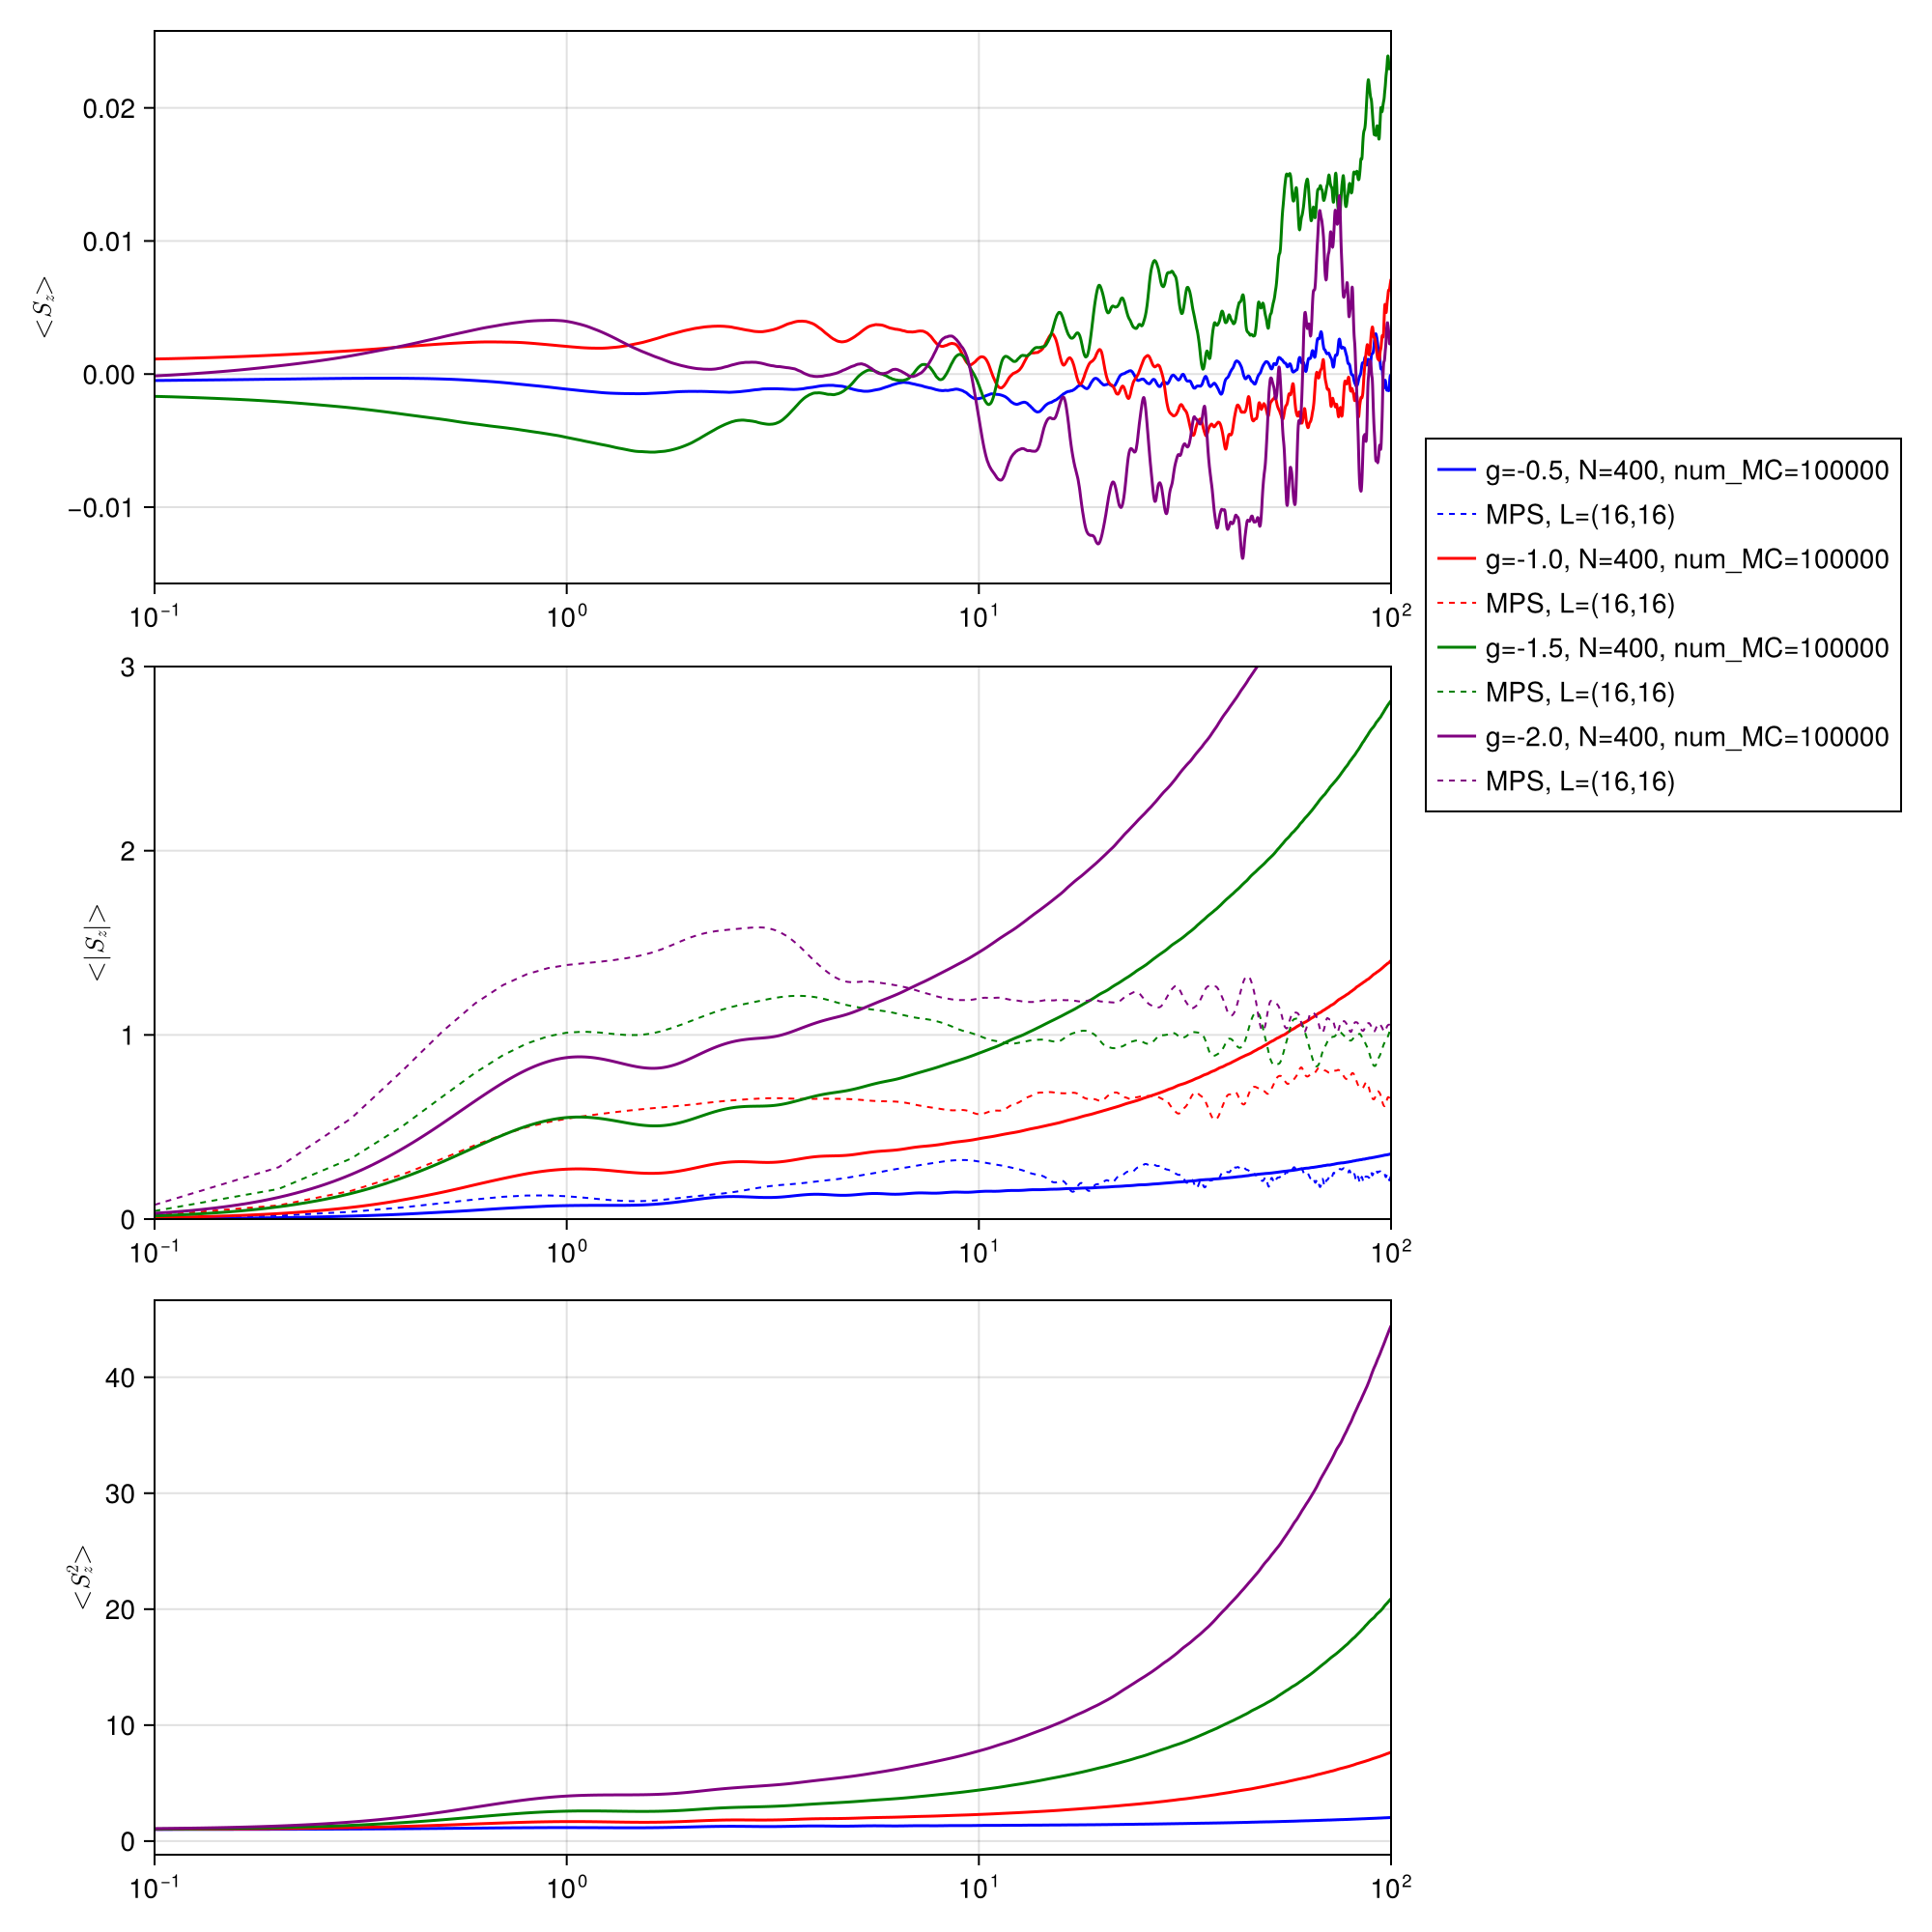

In [895]:
path = "/Users/wladi/Projects"

gs      = [-0.5,-1.0,-1.5,-2.0]#,-1.5]
Ns      = [400]
num_MCs = [100000]#, 10_000]
L=10

params = collect(Iterators.product(gs, Ns, num_MCs))

colors = [:blue, :red, :green, :purple, :black, :orange, :grey] 
fig = Figure(size=(1000,1000))
ax1 = Axis(fig[1,1], 
    xscale = log10, limits = ((0.1,100),(nothing,nothing)),
    ylabel = L"<S_z>",
)
ax2 = Axis(fig[2,1], 
    xscale = log10, limits = ((0.1,100),(0,3)),
    ylabel = L"<|S_z|>",
)
ax3 = Axis(fig[3,1], 
    xscale = log10, limits = ((0.1,100),(nothing,nothing)),
    ylabel = L"<S_z^2>",
)

data = map(enumerate(params)) do (i,(g, N, num_MC))
    S = div(N,2)
    name = path * "/TFIPerturbationTheory/data/TWA_SG_fockStateVar_L=$(L)_Sz=$(S)_num_MC=$(num_MC)_g=$(g).csv"
    df    = CSV.read(name, DataFrame)
    dfMPS = CSV.read("/Users/wladi/Projects/TFIPerturbationTheory/data/obs_hardcoreBosons_mps_new_L=16_Sz=8_g=$(g)_bondDim=64_tmax=100.csv", DataFrame)
    # return N, g, num_MC, df[1, "meanSz"]

    lines!(ax1, df[:,"t"], df[:,"meanSz"], color = colors[i], label = "g=$g, N=$N, num_MC=$(num_MC)")
    lines!(ax2, df[:,"t"], df[:,"absSz"] .- df[1,"absSz"],  color = colors[i], label = "g=$g, N=$N, num_MC=$(num_MC)")
    lines!(ax2, 0.1*collect(1:length(dfMPS[:, "Nabs"])), dfMPS[:, "Nabs"], label = "MPS, L=(16,16)", color = colors[i], linewidth = 1, linestyle = :dash)
    lines!(ax3, df[:,"t"], df[:,"meanSz2"], color = colors[i])
end
Legend(fig[1:2,2], ax2)

fig

### Initial Fock state with added variance and phi = 0

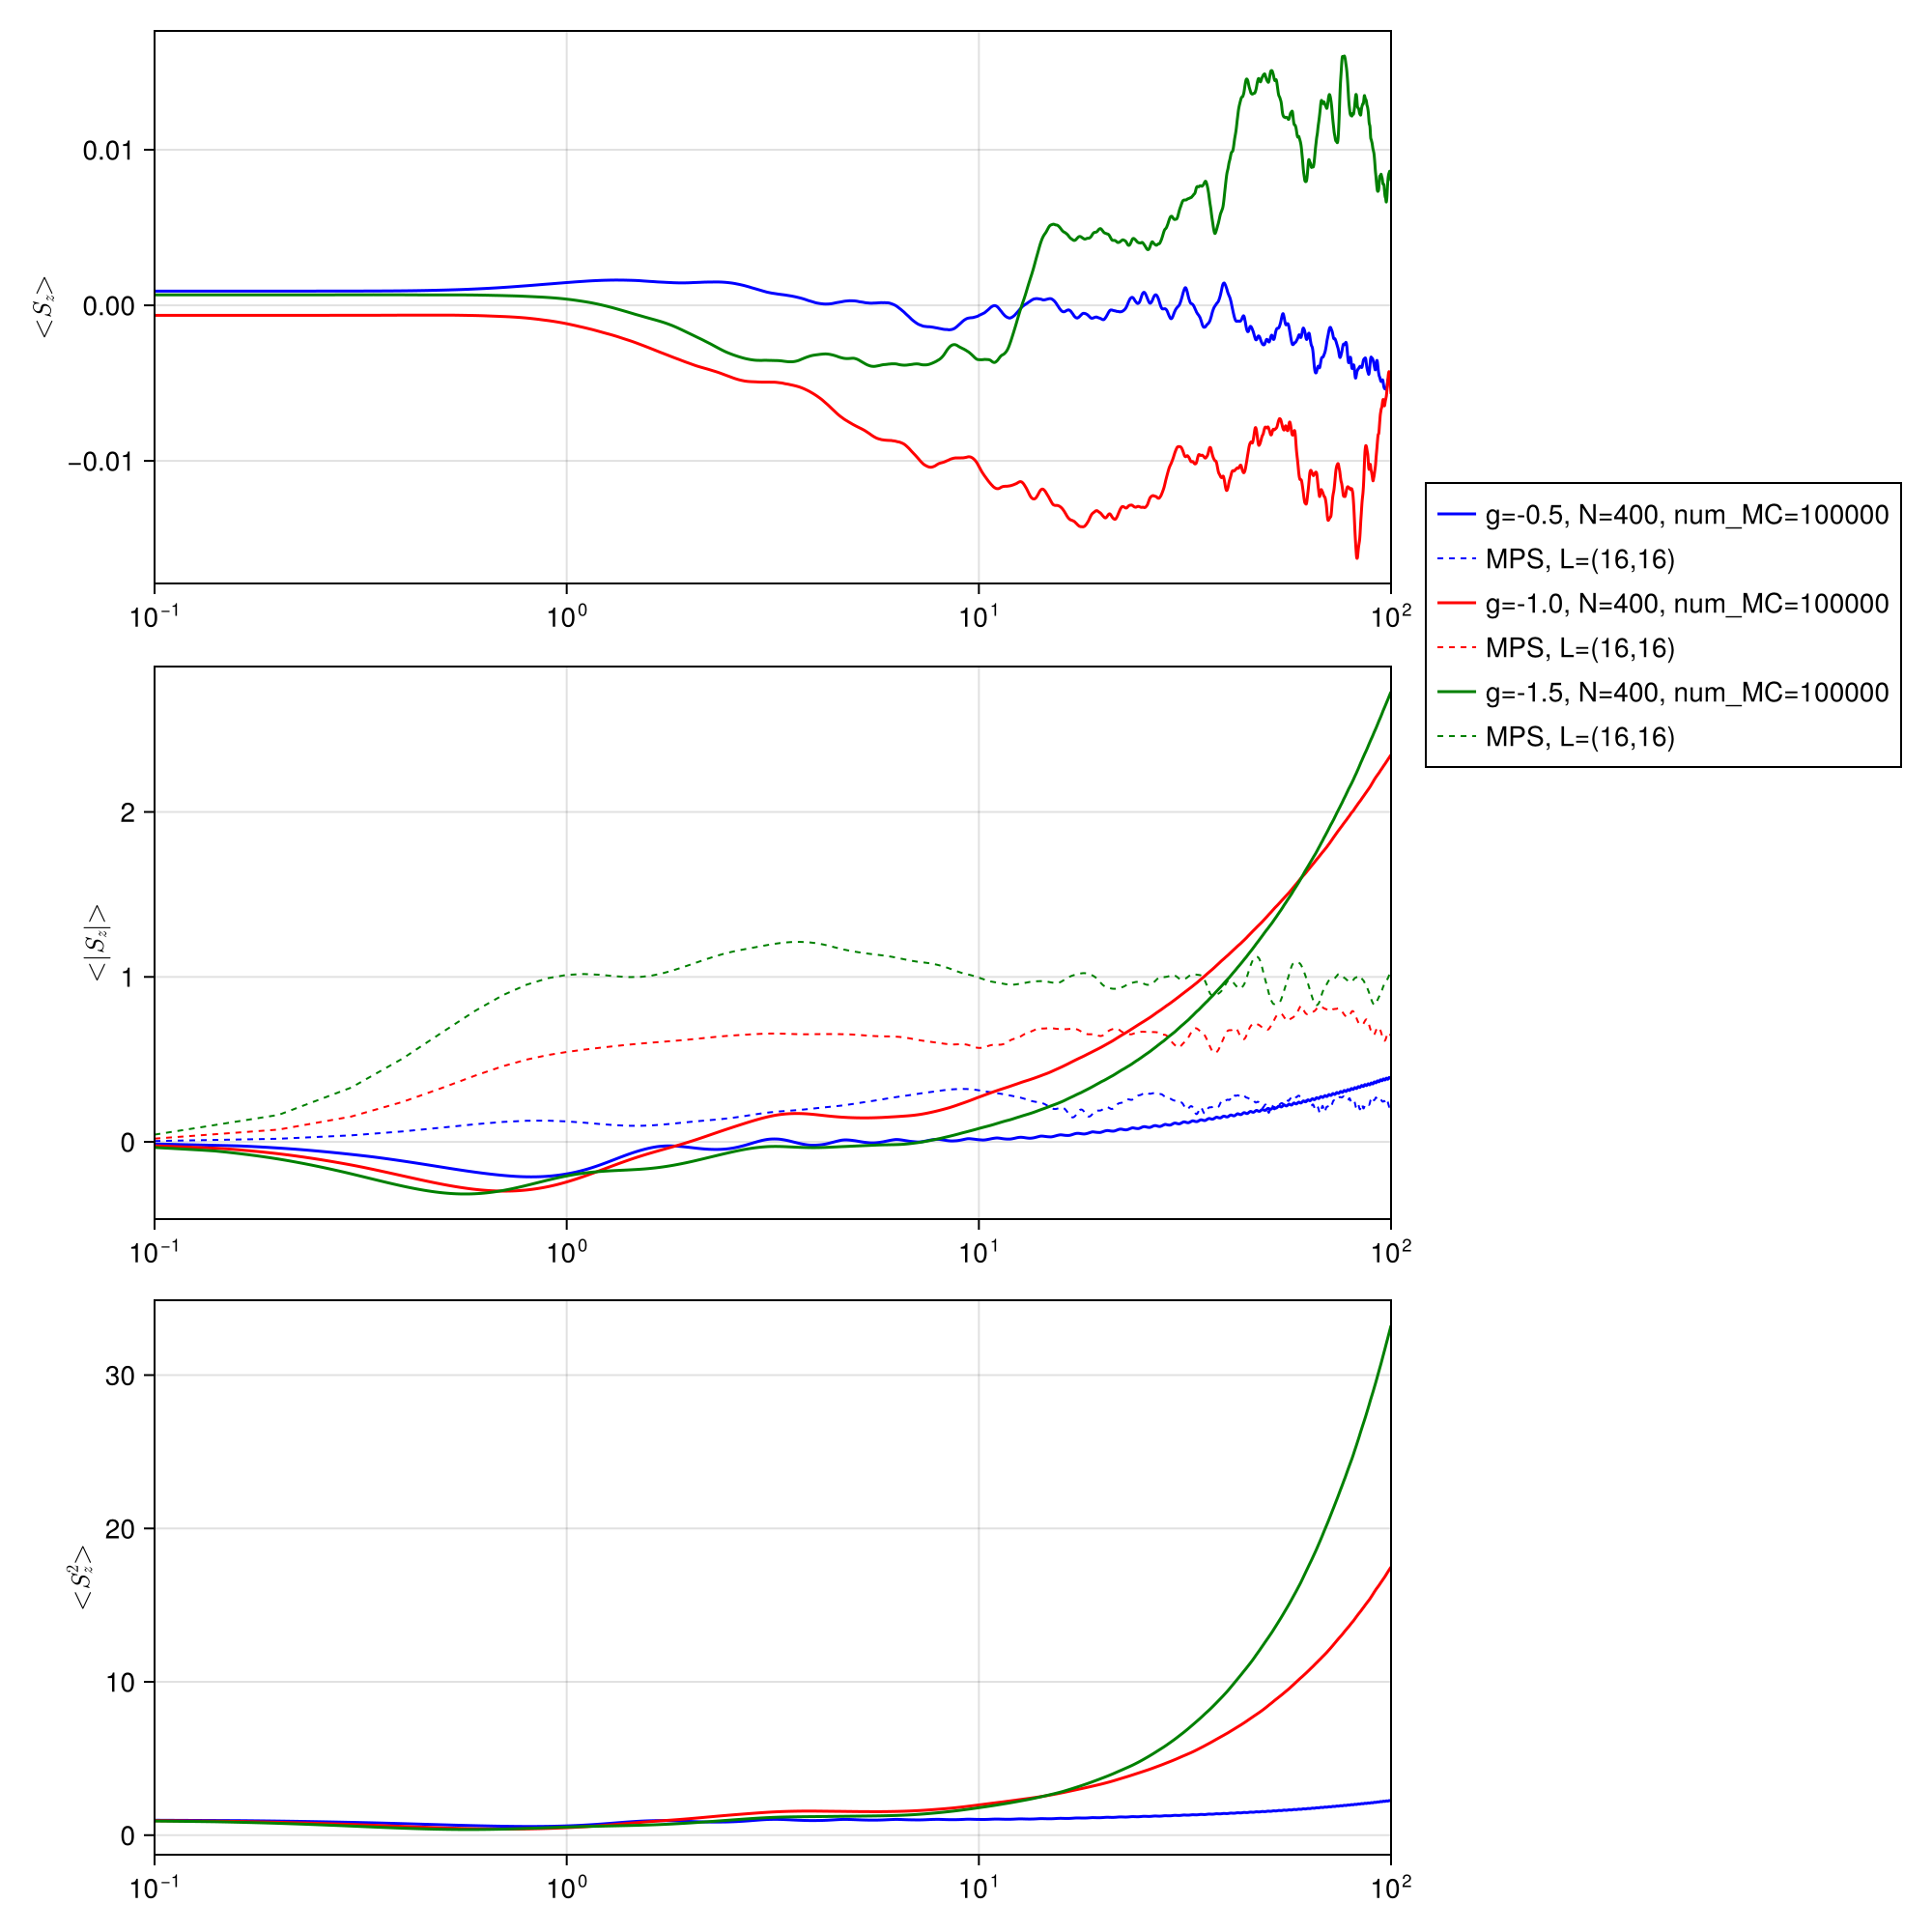

In [898]:
path = "/Users/wladi/Projects"

gs      = [-0.5,-1.0,-1.5]#,-2.0]#,-1.5]
Ns      = [400]
num_MCs = [100000]#, 10_000]
L=10

params = collect(Iterators.product(gs, Ns, num_MCs))

colors = [:blue, :red, :green, :purple, :black, :orange, :grey] 
fig = Figure(size=(1000,1000))
ax1 = Axis(fig[1,1], 
    xscale = log10, limits = ((0.1,100),(nothing,nothing)),
    ylabel = L"<S_z>",
)
ax2 = Axis(fig[2,1], 
    xscale = log10, limits = ((0.1,100),(nothing,nothing)),
    ylabel = L"<|S_z|>",
)
ax3 = Axis(fig[3,1], 
    xscale = log10, limits = ((0.1,100),(nothing,nothing)),
    ylabel = L"<S_z^2>",
)

data = map(enumerate(params)) do (i,(g, N, num_MC))
    S = div(N,2)
    name = path * "/TFIPerturbationTheory/data/TWA_SG_fockStateVar_phi=0_L=$(L)_Sz=$(S)_num_MC=$(num_MC)_g=$(g).csv"
    df    = CSV.read(name, DataFrame)
    dfMPS = CSV.read("/Users/wladi/Projects/TFIPerturbationTheory/data/obs_hardcoreBosons_mps_new_L=16_Sz=8_g=$(g)_bondDim=64_tmax=100.csv", DataFrame)
    # return N, g, num_MC, df[1, "meanSz"]

    lines!(ax1, df[:,"t"], df[:,"meanSz"], color = colors[i], label = "g=$g, N=$N, num_MC=$(num_MC)")
    lines!(ax2, df[:,"t"], df[:,"absSz"] .- df[1,"absSz"],  color = colors[i], label = "g=$g, N=$N, num_MC=$(num_MC)")
    lines!(ax2, 0.1*collect(1:length(dfMPS[:, "Nabs"])), dfMPS[:, "Nabs"], label = "MPS, L=(16,16)", color = colors[i], linewidth = 1, linestyle = :dash)
    lines!(ax3, df[:,"t"], df[:,"meanSz2"], color = colors[i])
end
Legend(fig[1:2,2], ax2)

fig

### Initial state via Laguerre Polyn. with phi random

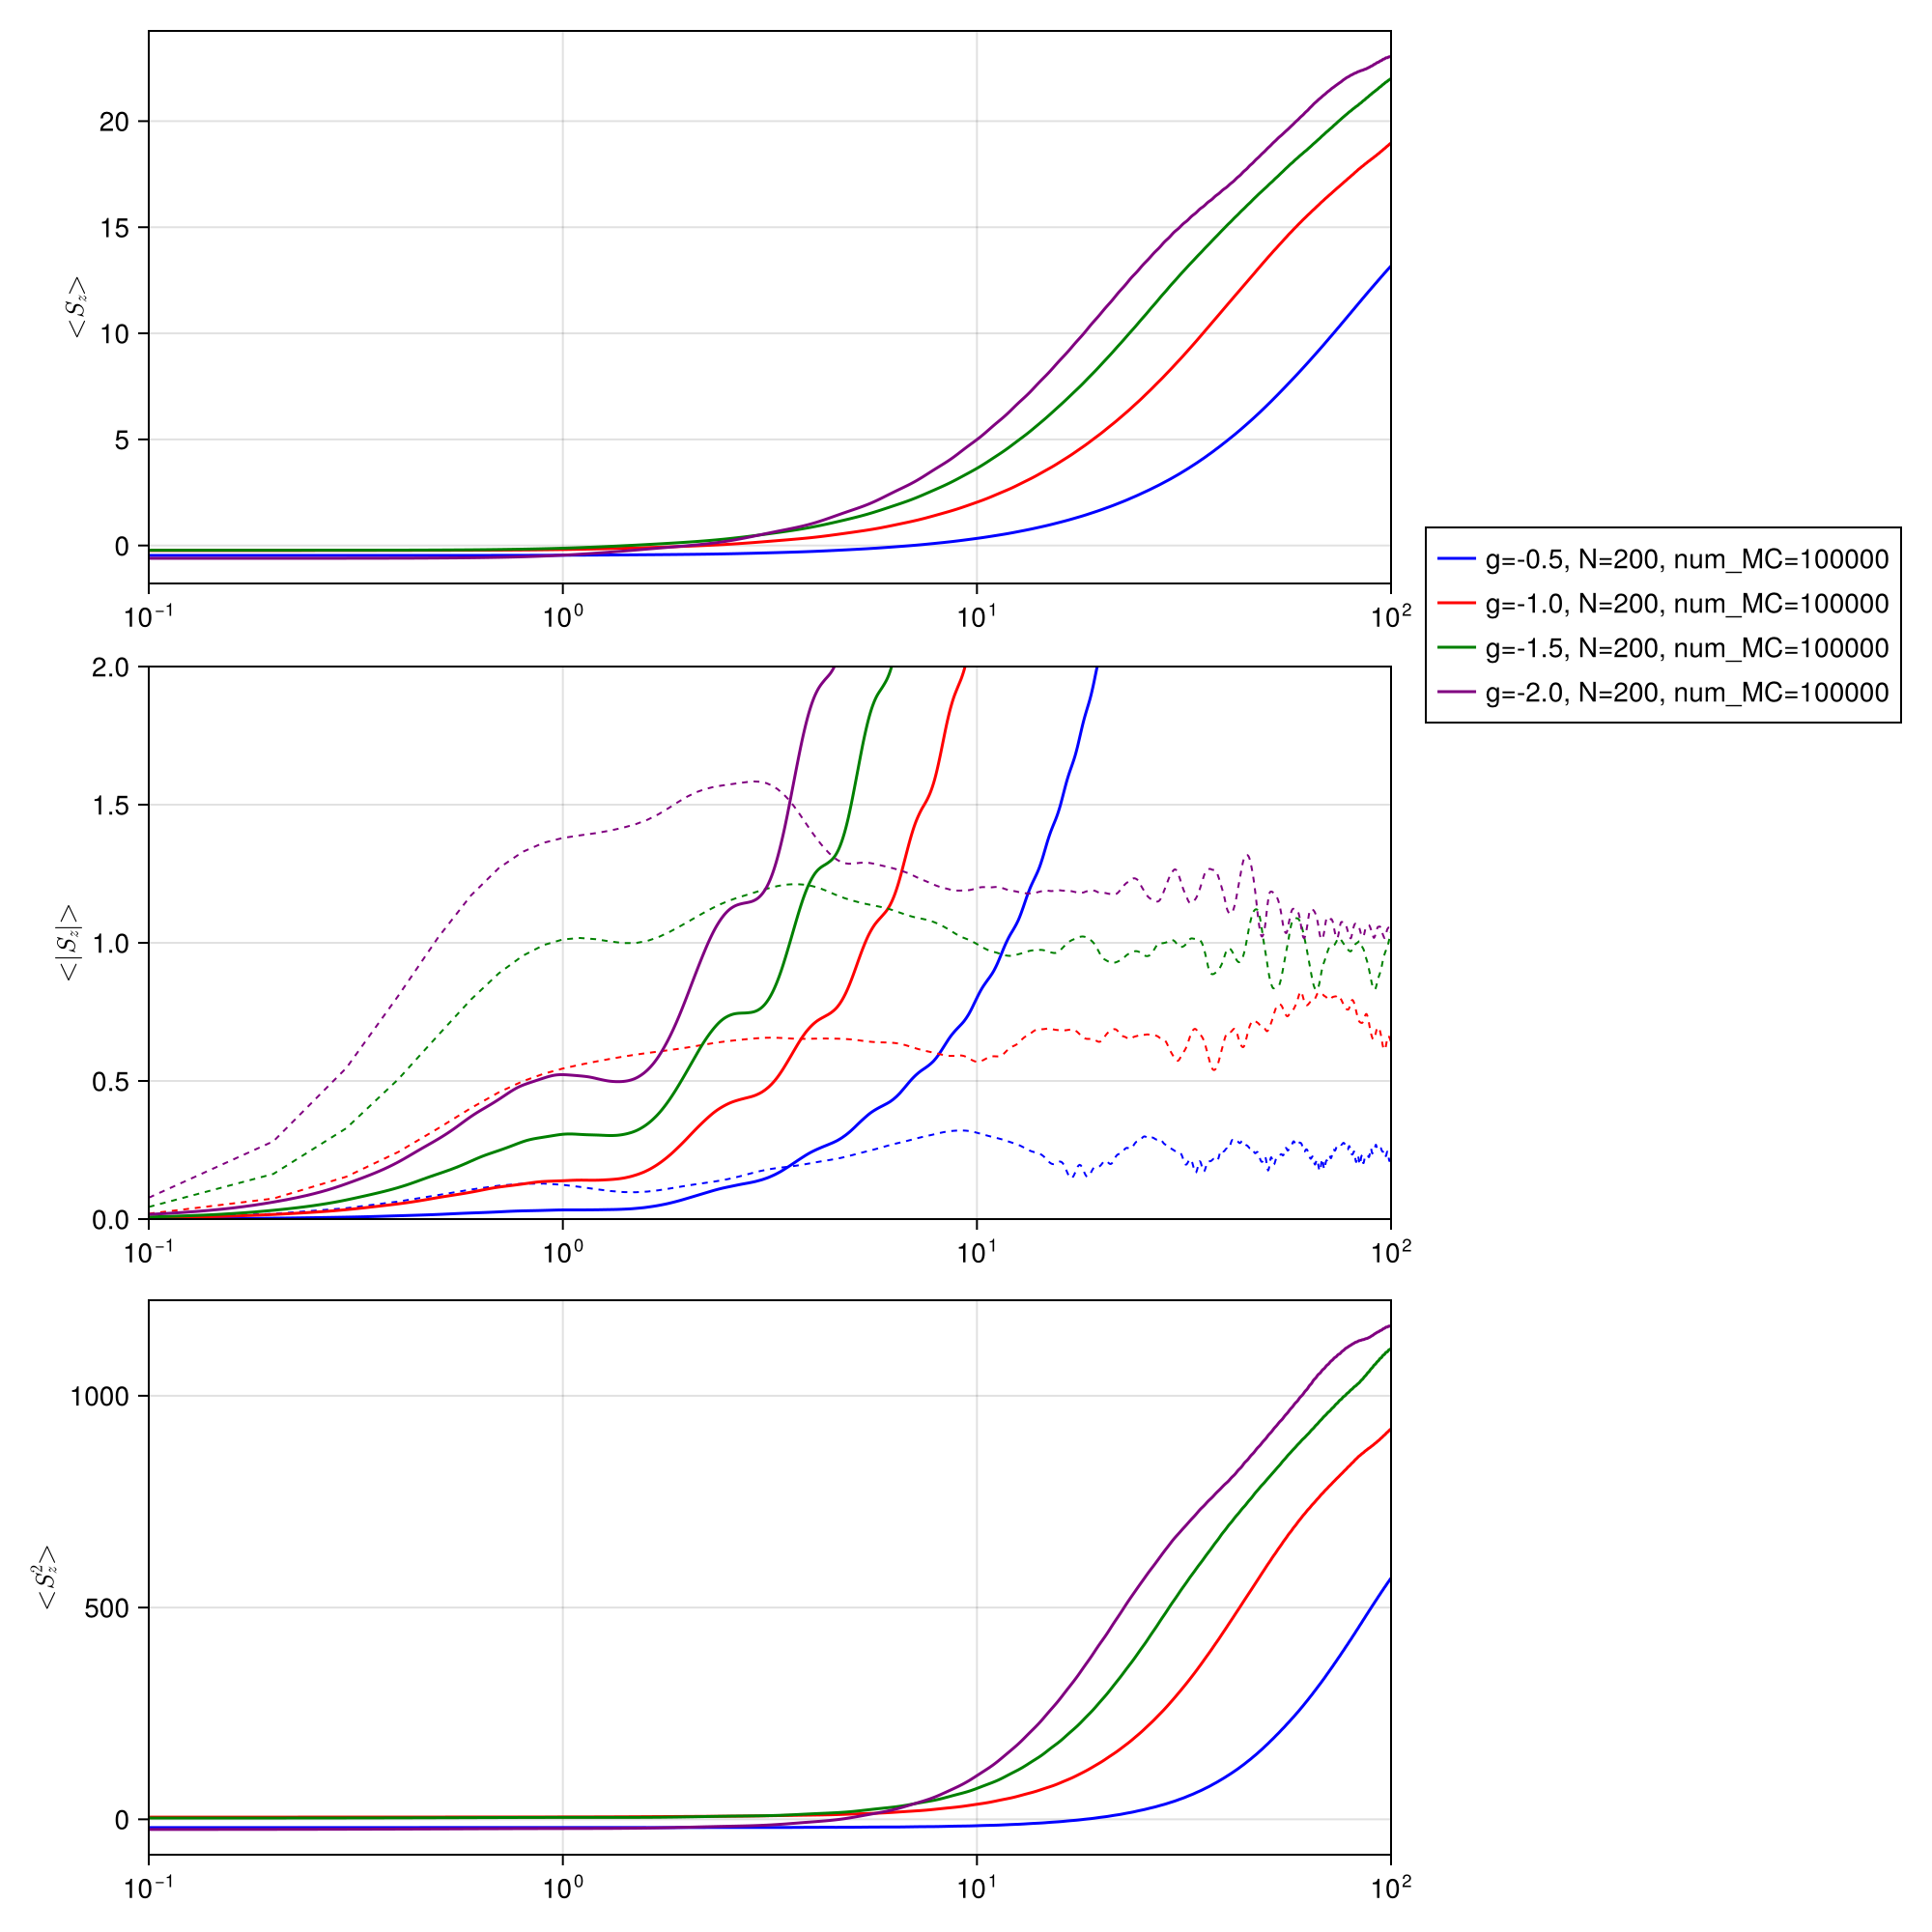

In [981]:
path = "/Users/wladi/Projects"

gs      = [-0.5,-1.0,-1.5,-2.0]#,-1.5]
Ns      = [200]
num_MCs = [100_000]
L=10

params = collect(Iterators.product(gs, Ns, num_MCs))

fig = Figure(size=(1000,1000))
ax1 = Axis(fig[1,1], 
    xscale = log10, limits = ((0.1,100),(nothing,nothing)),
    ylabel = L"<S_z>",
)
ax2 = Axis(fig[2,1], 
    xscale = log10, limits = ((0.1,100),(0,2)),
    ylabel = L"<|S_z|>",
)
ax3 = Axis(fig[3,1], 
    xscale = log10, limits = ((0.1,100),(nothing,nothing)),
    ylabel = L"<S_z^2>",
)

data = map(enumerate(params)) do (i,(g, N, num_MC))
    S = N/2
    name = path * "/TFIPerturbationTheory/data/TWA_SG_L=$(L)_Sz=$(S)_num_MC=$(num_MC)_g=$(g).csv"
    df = CSV.read(name, DataFrame)
    dfMPS = CSV.read("/Users/wladi/Projects/TFIPerturbationTheory/data/obs_hardcoreBosons_mps_new_L=16_Sz=8_g=$(g)_bondDim=64_tmax=100.csv", DataFrame)
    # return N, g, num_MC, df[1, "meanSz"]

    lines!(ax1, df[:,"t"], df[:,"meanSz"], color = colors[i], label = "g=$g, N=$N, num_MC=$(num_MC)")
    lines!(ax2, df[:,"t"], df[:,"absSz"] .- df[1,"absSz"],  color = colors[i], label = "g=$g, N=$N, num_MC=$(num_MC)")
    lines!(ax2, 0.1*collect(1:length(dfMPS[:, "Nabs"])), dfMPS[:, "Nabs"], label = "MPS, L=(16,16)", color = colors[i], linewidth = 1, linestyle = :dash)
    lines!(ax3, df[:,"t"], df[:,"meanSz2"], color = colors[i])
end
Legend(fig[1:2,2], ax1)

fig

# Runs

### g=-0.5

In [313]:
data05 = [];

L = 10
N = 200
S = div(N,2)
num_MC = 500

dt = 1e-2
T = 10.


J = -1;
# gs = [-0.25,-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0];
g = -0.5

params = (J,g,S)
obs = obs_SG2
F   = F_SG2

# create samples
samples, signs, prefactor = get_samples(N; n_samples = num_MC * L)

# @show length(samples), length(signs)

for (sample, sign) in zip(Iterators.partition(samples, L), Iterators.partition(signs, L))
    t = 0
    dataTemp = []
    @show sample
    # @show sign

    # n0 = fill(S, L)
    n0 = (S/2) * sample
    phi0 = 2*pi*rand(L)
    fields = (n0, phi0)

    # Compute time evolution
    try
        while t < T
            # push!(dataTemp, [t, sign, fields[1]]) #obs_SG2(fields, params)])
            meanSz = prefactor*mean(sign .* fields[1])
            absSz = prefactor*mean(sign .* abs.(S .- fields[1]))
            @show absSz
            push!(dataTemp, [t, meanSz, absSz])
            fields = heun_step(fields, params, F, dt)
            # dt_new, fields = adaptive_heun_step(fields, params, F, dt, 1e-1)
            t += dt
        end
    catch
        @warn "Error, fields = $fields"
        continue
    end
    push!(data05, dataTemp)
end

In [314]:
data05

500-element Vector{Any}:
 Any[[0.0, -24.25059290012483, 26.446385599470375], [0.01, -24.25186377159399, 26.43489172922034], [0.02, -24.253267537218445, 26.423462715688785], [0.03, -24.254819988971878, 26.412134880558508], [0.04, -24.25653668096193, 26.40094438364852], [0.05, -24.25843290454688, 26.389927165065977], [0.060000000000000005, -24.26052366387277, 26.379118887709634], [0.07, -24.262823651869926, 26.36855488021688], [0.08, -24.265347226747448, 26.35827008044543], [0.09, -24.26810838902313, 26.348298979580193]  …  [9.909999999999833, -35.28908026136737, 37.113018763942165], [9.919999999999833, -35.30688552930644, 37.13361681516526], [9.929999999999833, -35.32501337483149, 37.15503940520642], [9.939999999999833, -35.34345283495597, 37.17727030019076], [9.949999999999832, -35.36219244817652, 37.20029197312788], [9.959999999999832, -35.38122027280876, 37.22408563195136], [9.969999999999832, -35.400523906091664, 37.248631249582075], [9.979999999999832, -35.42009050402906, 37.273907

In [319]:
data05 = [];

L = 10
N = 200
S = div(N,2)
num_MC = 5000

dt = 1e-2
T = 10.


J = -1;
# gs = [-0.25,-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0];
g = -0.5

params = (J,g,S)
obs = obs_SG2
F   = F_SG2

# create samples
samples, signs, prefactor = get_samples(N; n_samples = num_MC * L)
# @show length(samples), length(signs)

for (sample, sign) in zip(Iterators.partition(samples, L), Iterators.partition(signs, L))
    t = 0
    dataTemp = []
    @show sample
    # @show sign

    # n0 = fill(S, L)
    n0 = (S/2) * sample
    phi0 = 2*pi*rand(L)
    fields = (n0, phi0)

    # Compute time evolution
    try
        while t < T
            # push!(dataTemp, [t, sign, fields[1]]) #obs_SG2(fields, params)])
            push!(dataTemp, [t, sign, obs_SG2(fields, params)])
            fields = heun_step(fields, params, F, dt)
            # dt_new, fields = adaptive_heun_step(fields, params, F, dt, 1e-1)
            t += dt
        end
    catch
        @warn "Error, fields = $fields"
        continue
    end
    push!(data05, dataTemp)
end

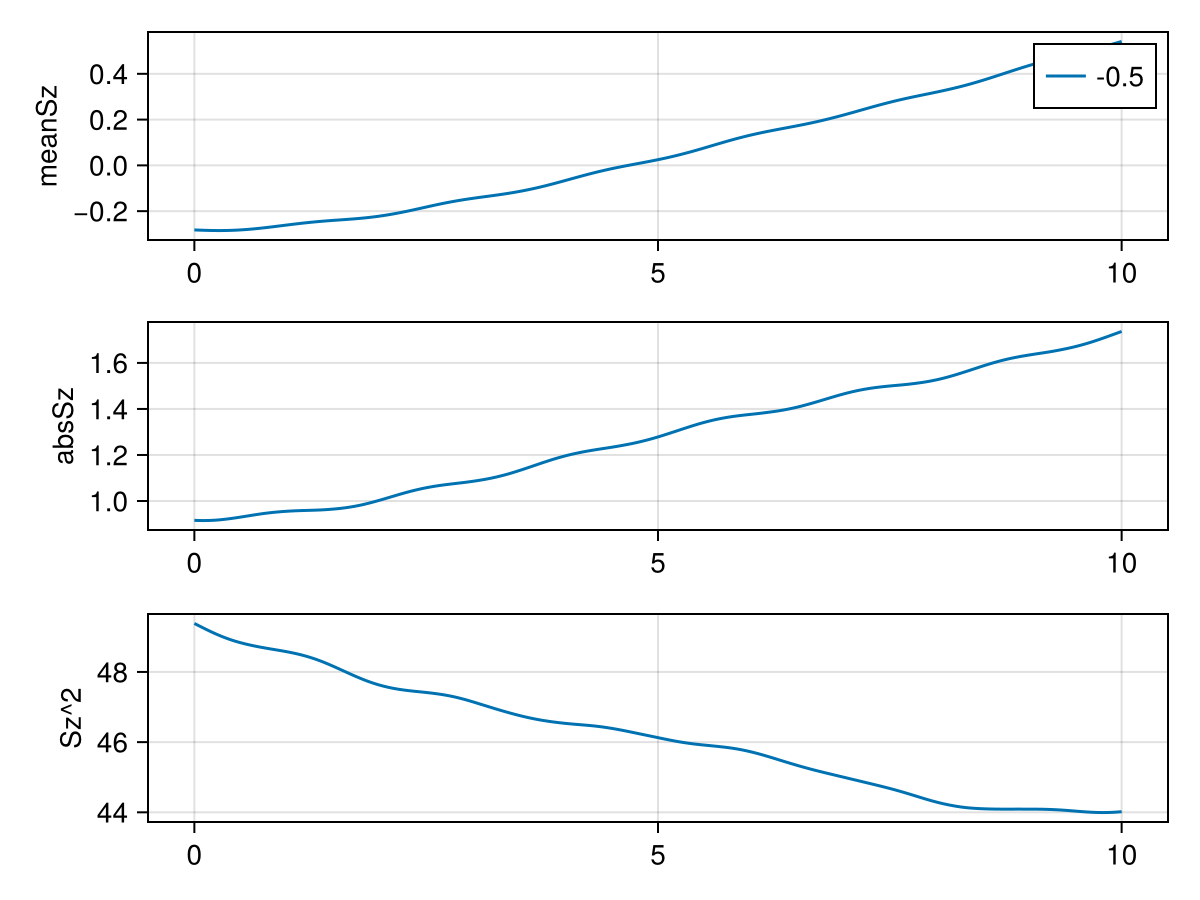

In [320]:
df05 = analyze_data(data05, params);

f  = Figure()
ax1 = Axis(f[1,1], ylabel = "meanSz")#, xscale = log10)
ax2 = Axis(f[2,1], ylabel = "absSz")#, xscale = log10)
ax3 = Axis(f[3,1], ylabel = "Sz^2")#, xscale = log10)

lines!(ax1, df05[:,"t"], prefactor .* df05[:,"meanSz"],  label = "-0.5")
lines!(ax2, df05[:,"t"], prefactor .* df05[:,"absSz"],   label = "-0.5")
lines!(ax3, df05[:,"t"], prefactor .* df05[:,"meanSz2"], label = "-0.5")

axislegend(ax1)

f

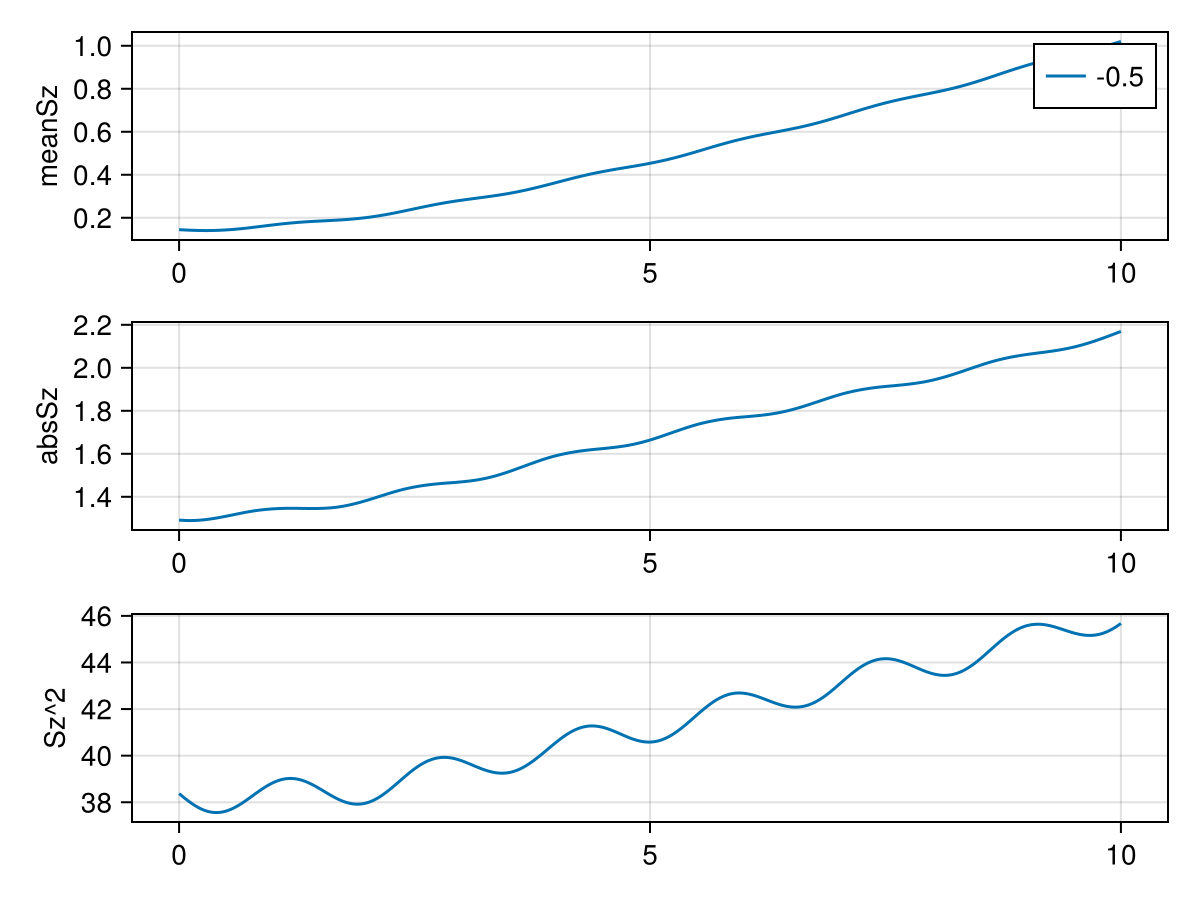

In [309]:
df05 = analyze_data(data05, params);

f  = Figure()
ax1 = Axis(f[1,1], ylabel = "meanSz")#, xscale = log10)
ax2 = Axis(f[2,1], ylabel = "absSz")#, xscale = log10)
ax3 = Axis(f[3,1], ylabel = "Sz^2")#, xscale = log10)

lines!(ax1, df05[:,"t"], prefactor .* df05[:,"meanSz"],  label = "-0.5")
lines!(ax2, df05[:,"t"], prefactor .* df05[:,"absSz"],   label = "-0.5")
lines!(ax3, df05[:,"t"], prefactor .* df05[:,"meanSz2"], label = "-0.5")

axislegend(ax1)

f

In [ ]:
function analyze_data3(data, params)
    _,_,S = params
    Sz = map(data) do data_t
        return map(data_t) do d
            return d[3]
        end
    end
    signs = map(data) do data_t
        return map(data_t) do d
            return d[2]
        end
    end

    meanSz  = [sum([mean(sign[i] .* s[i]) for (s,sign) in zip(Sz,signs)])/length(Sz) for i in 1:length(Sz[1])]
    meanSz2 = [sum([mean(sign[i] .* (s[i].^2)) for (s,sign) in zip(Sz,signs)])/length(Sz) for i in 1:length(Sz[1])]
    absSz   = [sum([mean(sign[i] .* abs.(s[i])) for (s,sign) in zip(Sz,signs)])/length(Sz) for i in 1:length(Sz[1])]
    # imb     = [sum([1-mean(abs.(s[i]))/S for s in Sz])/length(Sz) for i in 1:length(Sz[1])]

    # dw = [sum([sum([abs.(s1-s2) for (s1,s2) in zip(s, vcat(s[2:end],s[1]))]) for s in Sz])/length(Sz) for i in 1:length(Sz[1])]

    return DataFrame(
        t       = [real(d[1]) for d in data[1]], 
        meanSz  = meanSz,
        meanSz2 = meanSz2,
        absSz   = absSz,
        # imb     = imb,
        # dw      = dw,
        # sine    = [sum([d[i][6] for d in data])/N for i in 1:length(data[1])],
        # cosine  = [sum([d[i][7] for d in data])/N for i in 1:length(data[1])],
        # sine2   = [sum([d[i][8] for d in data])/N for i in 1:length(data[1])],
        # cosine2 = [sum([d[i][9] for d in data])/N for i in 1:length(data[1])],
        # imbS1   = [sum([d[i][10] for d in data])/N for i in 1:length(data[1])], 
    );
end

df05test = analyze_data3(data05, params);

f  = Figure()
ax1 = Axis(f[1,1], ylabel = "meanSz")#, xscale = log10)
ax2 = Axis(f[2,1], ylabel = "absSz")#, xscale = log10)
ax3 = Axis(f[3,1], ylabel = "Sz^2")#, xscale = log10)

lines!(ax1, df05test[:,"t"], prefactor .* df05test[:,"meanSz"],  label = "-0.5")
lines!(ax2, df05test[:,"t"], prefactor .* df05test[:,"absSz"],   label = "-0.5")
lines!(ax3, df05test[:,"t"], prefactor .* df05test[:,"meanSz2"], label = "-0.5")

axislegend(ax1)

f

### g=-1.5

In [199]:
data15 = [];

L = 10
N = 50
S = div(N,2)
num_MC = 5000

dt = 1e-2
T = 10.


J = -1;
gs = [-0.25,-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0];
g = -1.5

params = (J,g,S)
obs = obs_SG2
F   = F_SG2

# create samples
samples, signs, prefactor = get_samples(N; n_samples = num_MC * L)
# @show length(samples), length(signs)

for (sample, sign) in zip(Iterators.partition(samples, L), Iterators.partition(signs, L))
    t = 0
    dataTemp = []
    @show sample
    # @show sign

    # n0 = fill(S, L)
    n0 = (S/2) * sample
    phi0 = 2*pi*rand(L)
    fields = (n0, phi0)

    # Compute time evolution
    try
        while t < T
            # push!(dataTemp, [t, sign, fields[1]]) #obs_SG2(fields, params)])
            push!(dataTemp, [t, sign, obs_SG2(fields, params)])
            fields = heun_step(fields, params, F, dt)
            # dt_new, fields = adaptive_heun_step(fields, params, F, dt, 1e-1)
            t += dt
        end
    catch
        @warn "Error, fields = $fields"
        continue
    end
    push!(data15, dataTemp)
end

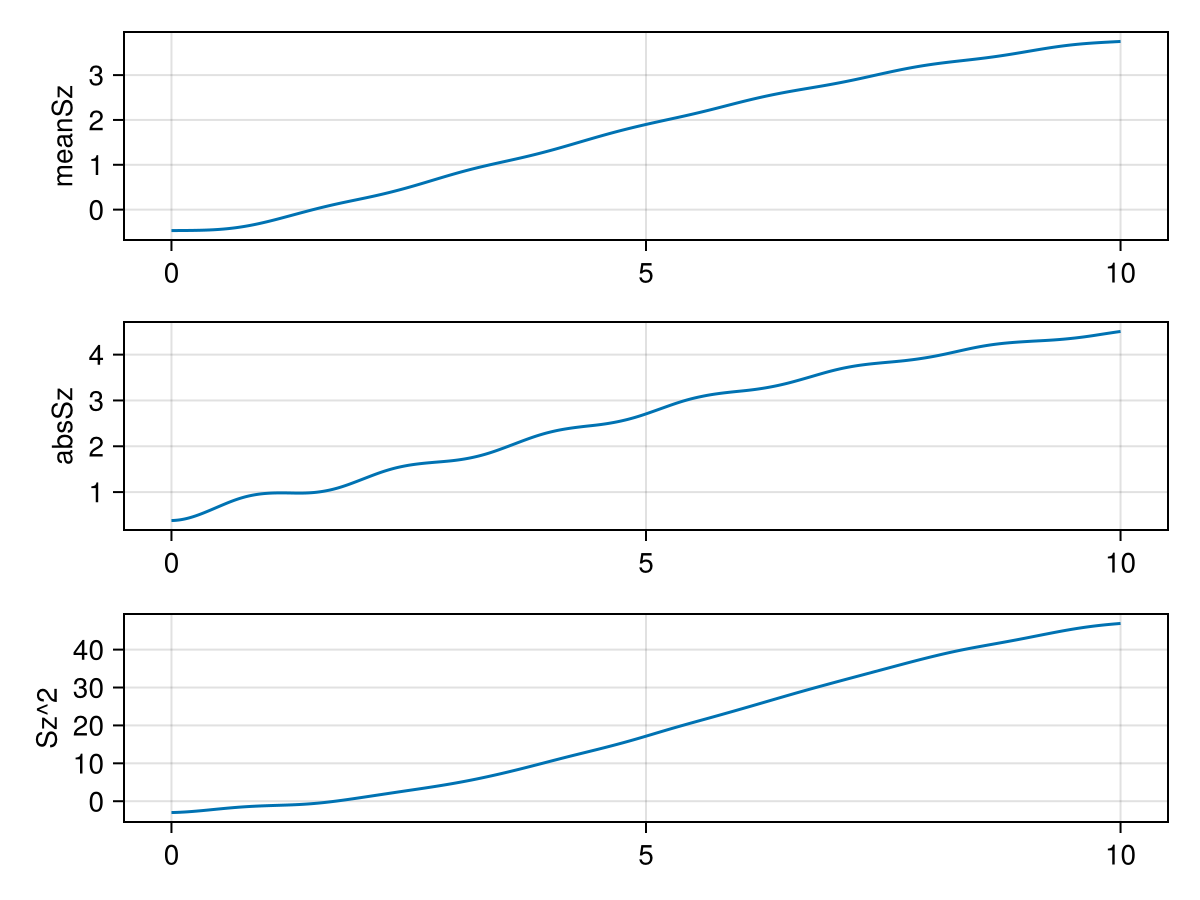

In [226]:
# df05 = analyze_data(data05, params);
df15 = analyze_data(data15, params);

f  = Figure()
ax1 = Axis(f[1,1], ylabel = "meanSz")#, xscale = log10)
ax2 = Axis(f[2,1], ylabel = "absSz")#, xscale = log10)
ax3 = Axis(f[3,1], ylabel = "Sz^2")#, xscale = log10)

lines!(ax1, df15[:,"t"], prefactor .* df15[:,"meanSz"],  label = "-1.5")
lines!(ax2, df15[:,"t"], prefactor .* df15[:,"absSz"],   label = "-1.5")
lines!(ax3, df15[:,"t"], prefactor .* df15[:,"meanSz2"], label = "-1.5")

axislegend(ax)

f

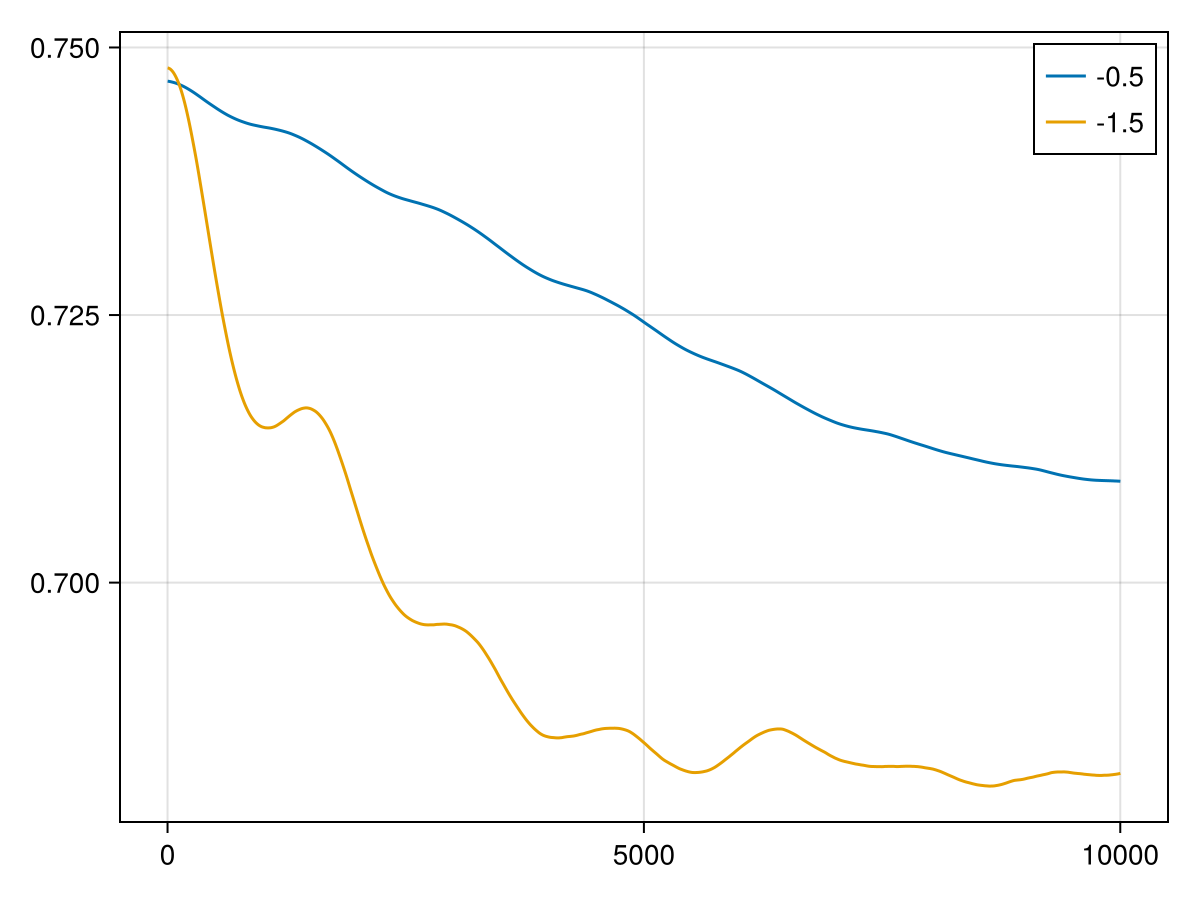

In [38]:
f  = Figure()
ax = Axis(f[1,1])#, xscale = log10)
lines!(ax, df05[:,"imb"], label = "-0.5")
lines!(ax, df15[:,"imb"], label = "-1.5")
axislegend(ax)
f
# plot!(L[1]*(1 .- dat[2][:,"imb"]), xaxis = :log)
# plot(dat[2][:,"meanSz"], xaxis = :log)

In [191]:
prefactor

6.458213821604485

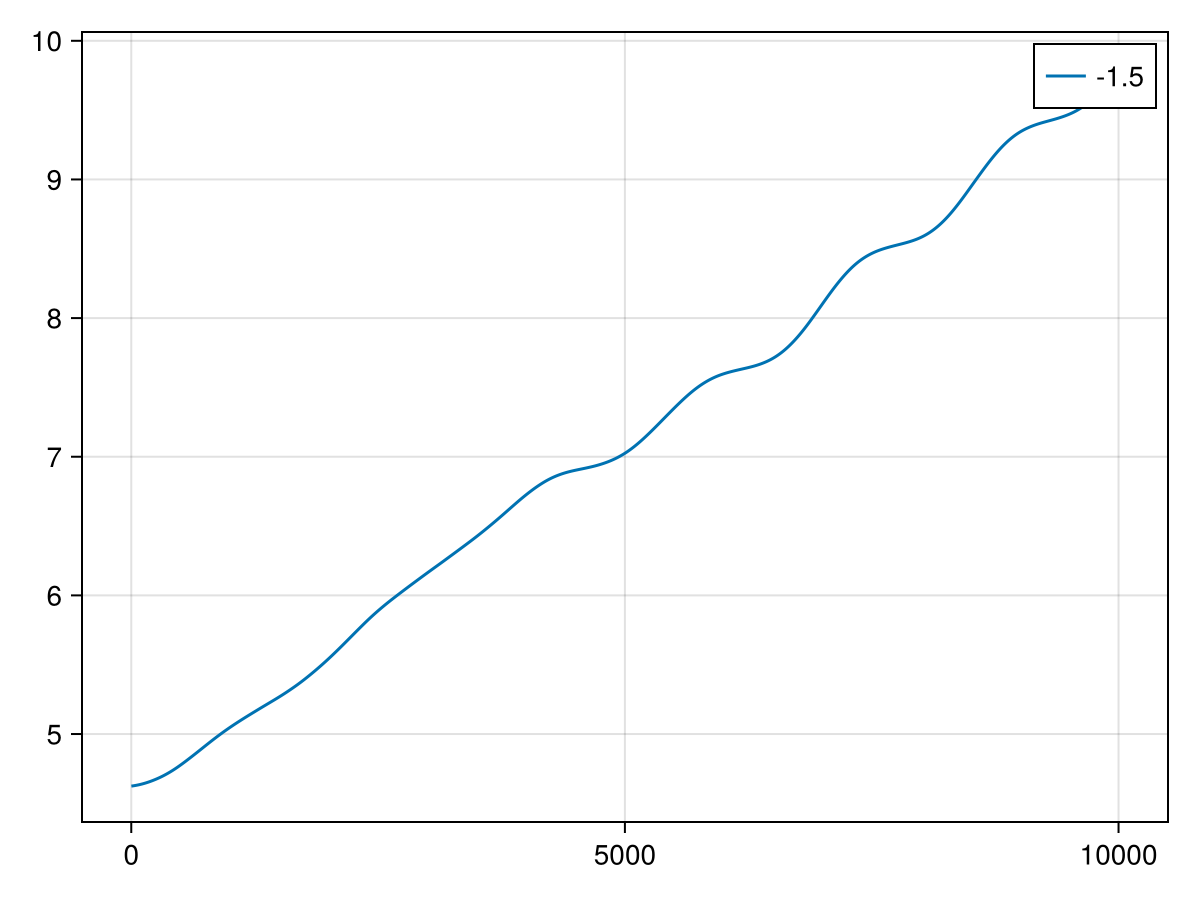

In [173]:
f  = Figure()
ax = Axis(f[1,1])#, xscale = log10)
# lines!(ax, df05[:,"imb"], label = "-0.5")
lines!(ax, prefactor .*df15[:,"meanSz"], label = "-1.5")
axislegend(ax)
f
# plot!(L[1]*(1 .- dat[2][:,"imb"]), xaxis = :log)
# plot(dat[2][:,"meanSz"], xaxis = :log)